# Подключение библиотек

In [1]:
using PyCall
np = pyimport("numpy")
using SymPy
using DifferentialEquations
using DynamicalSystems
using PyPlot
#using DiffEqDevTools
#using ProbNumDiffEq
#using OrdinaryDiffEq
using DiffEqCallbacks
#using DataFrames
using ForwardDiff
using BenchmarkTools
using JLD

In [1]:
#include("Utils\\BS_Sin_System.jl")
include("..\\Utils\\BS_Cos_System.jl")
#include("Utils\\BS_Uni_System.jl")
#include("Utils\\CallBack_Utils.jl")
#include("Utils\\Sol_Converter.jl")

#pushfirst!(PyVector(pyimport("sys")."path"), "")
#GU =  pyimport("graphics_utils")
mpc = pyimport("matplotlib.colors")
gridspec = pyimport("matplotlib.gridspec")

LoadError: UndefVarError: pyimport not defined

---

# Аналитический вывод собственных чисел для состояний равновесия

In [3]:
X = symbols("x1 x2 x3")
x = symbols("x")
a2, a4, K, r, Eps = symbols("a_2 a_4 K r varepsilon", real = True)

(a_2, a_4, K, r, varepsilon)

In [4]:
g4_1 = Lambda((x, a4), sin(x + a4))
g4_2 = Lambda((x, a4), (g4_1(-x, a4) - g4_1(x, a4))/2)

            sin(a_4 - x)   sin(a_4 + x)
(x, a_4) -> ------------ - ------------
                 2              2      

In [5]:
g2_1 = Lambda((x, a2, r), sin(x + a2) - r * sin(2*(x + a2)))
g2_2 = Lambda((x, a2, r), (g2_1(-x, a2, r) - g2_1(x, a2, r))/2)

                 r*sin(2*a_2 - 2*x)   r*sin(2*a_2 + 2*x)   sin(a_2 - x)   sin(
(x, a_2, r) -> - ------------------ + ------------------ + ------------ - ----
                         2                    2                 2             

a_2 + x)
--------
 2      

In [6]:
G = Lambda((X, a2, a4, K, r), 2 * g2_2(X[1], a2, r) - K/2 * (g4_2(X[3] + X[1], a4) + g4_2(X[1] - X[3], a4)) + K/2 * (g4_2(X[2] + X[1], a4) + g4_2(X[1] - X[2], a4)))

                                    /  sin(-a_4 + x1 + x2)   sin(a_4 - x1 + x2
                                  K*|- ------------------- + -----------------
                                    \           2                    2        
((x1, x2, x3), a_2, a_4, K, r) -> --------------------------------------------
                                                                             2

)   sin(a_4 + x1 - x2)   sin(a_4 + x1 + x2)\     /  sin(-a_4 + x1 + x3)   sin(
- - ------------------ - ------------------|   K*|- ------------------- + ----
            2                    2         /     \           2                
-------------------------------------------- - -------------------------------
                                                                              

a_4 - x1 + x3)   sin(a_4 + x1 - x3)   sin(a_4 + x1 + x3)\                     
-------------- - ------------------ - ------------------|                     
    2                    2                    2   

In [7]:
Single_Sys = [G((X[1], X[2], X[3]), a2, a4, K, r),
              G((X[2], X[3], X[1]), a2, a4, K, r),
              G((X[3], X[1], X[2]), a2, a4, K, r)]

3-element Vector{Sym}:
  K*(-sin(-a_4 + x1 + x2)/2 + sin(a_4 - x1 + x2)/2 - sin(a_4 + x1 - x2)/2 - sin(a_4 + x1 + x2)/2)/2 - K*(-sin(-a_4 + x1 + x3)/2 + sin(a_4 - x1 + x3)/2 - sin(a_4 + x1 - x3)/2 - sin(a_4 + x1 + x3)/2)/2 - r*sin(2*a_2 - 2*x1) + r*sin(2*a_2 + 2*x1) + sin(a_2 - x1) - sin(a_2 + x1)
 -K*(-sin(-a_4 + x1 + x2)/2 - sin(a_4 - x1 + x2)/2 + sin(a_4 + x1 - x2)/2 - sin(a_4 + x1 + x2)/2)/2 + K*(-sin(-a_4 + x2 + x3)/2 + sin(a_4 - x2 + x3)/2 - sin(a_4 + x2 - x3)/2 - sin(a_4 + x2 + x3)/2)/2 - r*sin(2*a_2 - 2*x2) + r*sin(2*a_2 + 2*x2) + sin(a_2 - x2) - sin(a_2 + x2)
  K*(-sin(-a_4 + x1 + x3)/2 - sin(a_4 - x1 + x3)/2 + sin(a_4 + x1 - x3)/2 - sin(a_4 + x1 + x3)/2)/2 - K*(-sin(-a_4 + x2 + x3)/2 - sin(a_4 - x2 + x3)/2 + sin(a_4 + x2 - x3)/2 - sin(a_4 + x2 + x3)/2)/2 - r*sin(2*a_2 - 2*x3) + r*sin(2*a_2 + 2*x3) + sin(a_2 - x3) - sin(a_2 + x3)

In [8]:
Jac = Lambda((X, a2, a4, K, r), Single_Sys.jacobian(X))

                                  [  /  cos(-a_4 + x1 + x2)   cos(a_4 - x1 + x
                                  [K*|- ------------------- - ----------------
                                  [  \           2                    2       
                                  [-------------------------------------------
                                  [                                           
                                  [                                           
                                  [                                           
                                  [                                           
((x1, x2, x3), a_2, a_4, K, r) -> [                                           
                                  [                                           
                                  [                                           
                                  [                                           
                                  [                 

In [9]:
Lambda_DSS = Jac((pi, 0, 0), a2, a4, K, r).simplify()
Lambda_DSS = [Lambda_DSS[0, 0], Lambda_DSS[1, 1], Lambda_DSS[2, 2]]

3-element Vector{Sym}:
      -8.0*r*sin(a_2)^2 + 4.0*r + 2.0*cos(a_2)
 -2.0*K*cos(a_4) + 4*r*cos(2*a_2) - 2*cos(a_2)
  2.0*K*cos(a_4) + 4*r*cos(2*a_2) - 2*cos(a_2)

In [10]:
Lambda_DSS = lambdify(Lambda_DSS, [a2, a4, K, r])

#109 (generic function with 1 method)

In [11]:
Lambda_DDS = Jac((pi, pi, 0), a2, a4, K, r).simplify()
Lambda_DDS = [Lambda_DDS[0, 0], Lambda_DDS[1, 1], Lambda_DDS[2, 2]]

3-element Vector{Sym}:
 -2.0*K*cos(a_4) - 8.0*r*sin(a_2)^2 + 4.0*r + 2.0*cos(a_2)
  2.0*K*cos(a_4) - 8.0*r*sin(a_2)^2 + 4.0*r + 2.0*cos(a_2)
                               4*r*cos(2*a_2) - 2*cos(a_2)

In [12]:
Lambda_DDS = lambdify(Lambda_DDS, [a2, a4, K, r])

#109 (generic function with 1 method)

---

# Вспомогательные структуры с информацией о системе

In [13]:
struct NumericParameters
    System; alg; startPt; Int_Time; LE_Time; Ttr; dt; abstol; reltol; maxiters
end

struct SystemParameters
    K; a2; a4; r; Eps_mesh
end

# Вспомогательные методы

In [14]:
function LEs_execution(SP, NP)
#@time begin
    λs = zeros(length(SP.Eps_mesh), 7)
        Threads.@threads for k = 1 : length(SP.Eps_mesh)
            Eps = SP.Eps_mesh[k]
            prob_julia = ODEProblem(NP.System, NP.startPt, (0.0, NP.Int_Time), [SP.K, SP.a2, SP.a4, SP.r, Eps])

            # Запуск траектории для проверки на влипание в седло ඞ
            sol_julia = solve(prob_julia, alg = NP.alg, abstol = NP.abstol, reltol = NP.reltol, adaptive=true, dt = NP.dt, maxiters = NP.maxiters, save_everystep=false)

            # Проверка на влипание в седло и дальнейший расчет спектра показателей
            if !(all(i->(-1e-5<=i<=1e-5), [sin(p) for p = sol_julia.u[end]]))
                λs[k, 7] = 1
            end
            lvDs = ContinuousDynamicalSystem(NP.System, NP.startPt, [SP.K, SP.a2, SP.a4, SP.r, Eps])
            λs[k, 1:6] .= lyapunovspectrum(lvDs, NP.LE_Time; diffeq = (Ttr = NP.Ttr, alg = NP.alg, abstol = NP.abstol, reltol = NP.reltol, maxiters = NP.maxiters, dt = NP.dt))
        end
#    end
    return λs
end

LEs_execution (generic function with 1 method)

# Вспомогательные методы для рисования графиков

In [15]:
function LLE_plot(λs, SP, NP)
fig = figure(figsize=(8, 4))
    
    plot(SP.Eps_mesh, λs[:, 1:6], linewidth = 3)
    plot([SP.Eps_mesh[1], SP.Eps_mesh[end]], [0, 0], "k--")
    
    myCmap = mpc.ListedColormap([[1, 0.7, 0.7], [1, 1, 1], [0.7, 1, 0.7]]);
    ColorVal = zeros(length(SP.Eps_mesh), 2)

    for i = 1 : length(SP.Eps_mesh)
        if any(i -> abs(i) < 1e-3, λs[i, 1:6])
            ColorVal[i, :] = ColorVal[i, :] + [1, 1]
            if any(i -> i > 1e-3, λs[i, 1:6])
                ColorVal[i, :] = ColorVal[i, :] + [1, 1]
            end
        end
        if λs[i, 7] == 0
            scatter(SP.Eps_mesh[i], 0, zorder = 100, color = "red") 
        end
    end
    
    plt.pcolor(SP.Eps_mesh, [-10, 10], ColorVal', cmap = myCmap, vmin=minimum(0), vmax=maximum(2))
    
    
    xlabel("\$\\varepsilon\$",fontsize=20)
    ylabel("\$\\lambda\$",fontsize=20)
    title("Int_Alg: \"" * string(NP.alg) * "\", Sys: \"" * string(NP.System) * "\", Int_Time: " * string(NP.Int_Time) * ", LE_Time: " * string(NP.LE_Time) * "\n" *
      "[K, a2, a4, r] = [" * string(SP.K) *", "* string(SP.a2) *", "* string(SP.a4) *", "* string(SP.r) * "]," * "\n" *
      "Eps_Mesh: " * string(SP.Eps_mesh[1]) * " - " * string(SP.Eps_mesh[end]) * ", Num of mesh nodes: " * string(length(SP.Eps_mesh)))
    
    fig.tight_layout(pad=0.3)
    fig.gca().set_xscale("log")
    fig.gca().set_ylim([1.1*minimum(λs[:, 1:6]), max(1.1*maximum(λs[:, 1:6]), 0.1)])


    tick_params(which="major", width=1.0, labelsize=14)
    tick_params(which="major", length=5, labelsize=14)
    #plt.savefig(alg_name * ".pdf", dpi=120, format="pdf", bbox_inches="tight")

    return fig
end

LLE_plot (generic function with 1 method)

In [16]:
function Plot_map(A2, A4, Array, title_name, POI)
    #plt.style.use("dark_background")
    cmap = plt.cm.plasma_r
    
    fig = figure(figsize=(6, 5))

    #cmap = matplotlib.cm.viridis
    
    bounds = sort(unique(Array))
    if isnan(bounds[end])
        bounds = bounds[1 : end-1]
    end
    
    if length(bounds) <= 50
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend="both")
        pcm = plt.pcolormesh(A2, A4, Array', cmap = cmap, vmin=minimum(bounds), vmax=maximum(bounds))
        cbar = colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
    else
        pcm = plt.pcolormesh(A2, A4, Array', cmap = cmap, vmin=minimum(bounds), vmax=maximum(bounds))
        cbar = colorbar(pcm)
    end
    cbar.ax.tick_params(labelsize=12)
    
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);
    
    plt.xlabel(L"$a_2$", fontsize=20)
    plt.ylabel(L"$a_4$", fontsize=20)
    
    plt.xticks(range(A2[1], A2[end], length = 5), fontsize=12);
    plt.yticks(range(A4[1], A4[end], length = 8), fontsize=12);
    
    title(title_name)
    
    if !isempty(POI)
        for i = 1 : length(POI)
            scatter(A2[POI[i][1]], A4[POI[i][2]], color = "red", marker = "x")
        end
    end

    #plt.style.use("default")
end

Plot_map (generic function with 1 method)

# Параметры системы

In [17]:
# Система и ее якобиан
System = BS_Cos_Sys
Jac = BS_Cos_Jac

Resolution = 500
Eps_Length = 10

#Eps_Length = 9

#Rate_Arr = zeros(Resolution, Resolution);

# Параметры системы
K = 0.4
#A2 = range(pi/2 - pi/18, pi/2 + pi/18, length = Resolution)
#A4 = range(pi - pi/8, pi + pi/8, length = Resolution)

A2 = range(pi/2, pi/2 + pi/16, step = pi/(16 * Resolution))
A4 = range(pi, pi + pi/8, step = pi/(8 * Resolution))

#A2 = range(0, 2*pi, length = Resolution)
#A4 = range(0, 2*pi, length = Resolution)

#A2 = pi/2
#A4 = range(pi, pi + pi/16, length = Resolution)

#A4 = range(2.75, 3.55, length = Resolution)
r = 0.1

Eps_mesh = exp10.(range(-8, -5, length=Eps_Length))
#Eps_mesh = exp10.(range(-7, -3, length=Eps_Length))

#SP = SystemParameters(K, A2, A4, r, Eps_mesh)

# Численные параметры
val = 0.0001
startPt = [pi - val; 0 + val; 0 + val;
           pi - val; 0 + val; pi - val]

Int_Time = 1000000.0
LE_Time = 100000.0
Ttr = 5000

dt = 1e-3
abstol = 1e-15
reltol = 1e-15
maxiters = 1e10
alg = DP8()

NP = NumericParameters(System, alg, startPt, Int_Time, LE_Time, Ttr, dt, abstol, reltol, maxiters)

#SI = SystemInformation(NP, SP, System, Jac, CB_Cond); dump(SI)

NumericParameters(BS_Cos_Sys, DP8(), [3.141492653589793, 0.0001, 0.0001, 3.141492653589793, 0.0001, 3.141492653589793], 1.0e6, 100000.0, 5000, 0.001, 1.0e-15, 1.0e-15, 1.0e10)

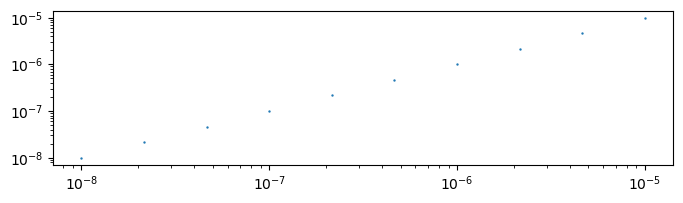

In [18]:
fig = figure(figsize=(8, 2))
scatter(Eps_mesh, Eps_mesh, s = 0.5)
fig.gca().set_xscale("log")
fig.gca().set_yscale("log")

In [19]:
Threads.nthreads()

1

In [97]:
accepted_points = zeros(length(A2), length(A4));

for ((i, a2_cur), (j, a4_cur)) = [[p, m] for p in enumerate(A2) for m in enumerate(A4)]

    lambda_DSS_cur = Lambda_DSS(a2_cur, a4_cur, K, r)
    lambda_DDS_cur = Lambda_DDS(a2_cur, a4_cur, K, r)
        
    if (lambda_DSS_cur[3] < lambda_DSS_cur[1] < 0 < lambda_DSS_cur[2]) &
        (lambda_DDS_cur[2] < lambda_DDS_cur[3] < 0 < lambda_DDS_cur[1]) &
        (1 <= (-lambda_DSS_cur[1] / lambda_DSS_cur[2]) * (-lambda_DDS_cur[3] / lambda_DDS_cur[1]) <= 1.1) #&
    #if 1 <= (-lambda_DSS_cur[1] / lambda_DSS_cur[2]) <= 1.1
    #if    ((1 < -lambda_DSS_cur[1] / lambda_DSS_cur[2] < 1.1) | (1 < -lambda_DDS_cur[3] / lambda_DDS_cur[1] < 1.1))
        
        
        #accepted_points[i, j] = 1;
        #accepted_points[i, j] = min(-lambda_DSS_cur[1] / lambda_DSS_cur[2], -lambda_DDS_cur[3] / lambda_DDS_cur[1])
        accepted_points[i, j] = (-lambda_DSS_cur[1] / lambda_DSS_cur[2]) * (-lambda_DDS_cur[3] / lambda_DDS_cur[1])
        #accepted_points[i, j] = (-lambda_DDS_cur[3] / lambda_DDS_cur[1])

    else
        accepted_points[i, j] = NaN
    end
end

In [ ]:
print(accepted_points)

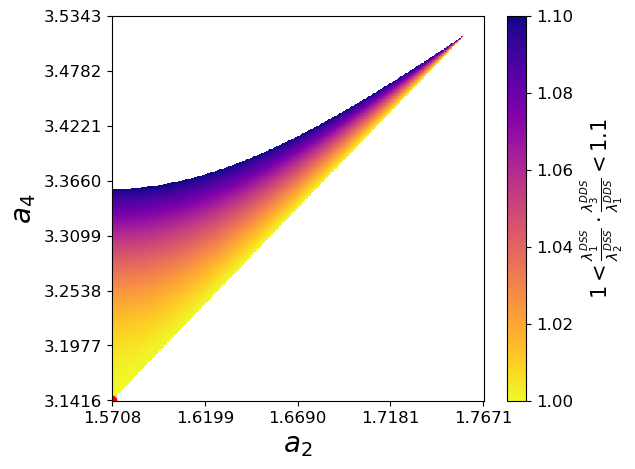

In [106]:
#plt.style.use("dark_background")

cmap = plt.cm.plasma_r

fig = figure(figsize=(6, 5))
#pcm = plt.pcolormesh(A2, A4, cmap = cmap, accepted_points', shading="nearest", vmin=minimum(sort(unique(accepted_points))[1:end-1]), vmax=maximum(sort(unique(accepted_points))[1:end-1]))
pcm = plt.pcolormesh(A2, A4, cmap = cmap, accepted_points', shading="nearest", vmin=minimum(1), vmax=maximum(1.1))
#colorbar(pcm, label = L"min(-\frac{\lambda_1^{DSS}}{\lambda_2^{DSS}}, -\frac{\lambda_3^{DDS}}{\lambda_1^{DDS}})")
cbar = colorbar(pcm)
cbar.set_label(label = L"1 < \frac{\lambda_1^{DSS}}{\lambda_2^{DSS}} \cdot \frac{\lambda_3^{DDS}}{\lambda_1^{DDS}} < 1.1", size=15) 
cbar.ax.tick_params(labelsize=12) 
scatter(pi/2, pi, color = "red")

plt.xlabel(L"$a_2$", fontsize=20)
plt.ylabel(L"$a_4$", fontsize=20)

plt.xticks(range(A2[1], A2[end], length = 5), fontsize=12);
plt.yticks(range(A4[1], A4[end], length = 8), fontsize=12);

#plt.title("K = " *  string(K)  * ", r = " * string(r))

#plt.style.use("default")

In [81]:
accepted_points = zeros(Resolution, Resolution);
KK = range(0, 2, length = Resolution)
RR = range(0, 1, length = Resolution)

for ((i, K_cur), (j, R_cur)) = [[p, m] for p in enumerate(KK) for m in enumerate(RR)]

    lambda_DSS_cur = Lambda_DSS(pi/2, pi, K_cur, R_cur)
    lambda_DDS_cur = Lambda_DDS(pi/2, pi, K_cur, R_cur)
        
    if (lambda_DSS_cur[3] < lambda_DSS_cur[1] < 0 < lambda_DSS_cur[2]) &
        (lambda_DDS_cur[2] < lambda_DDS_cur[3] < 0 < lambda_DDS_cur[1]) &
        (1 <= (-lambda_DSS_cur[1] / lambda_DSS_cur[2]) * (-lambda_DDS_cur[3] / lambda_DDS_cur[1]) <= 1.1)# &
    #    (1 <= (-lambda_DSS_cur[1] / lambda_DSS_cur[2])) & (1 <= (-lambda_DDS_cur[3] / lambda_DDS_cur[1]))
        
        #accepted_points[i, j] = 1;
        accepted_points[i, j] = (-lambda_DSS_cur[1] / lambda_DSS_cur[2]) * (-lambda_DDS_cur[3] / lambda_DDS_cur[1])
        
    else
        accepted_points[i, j] = NaN
    end
end

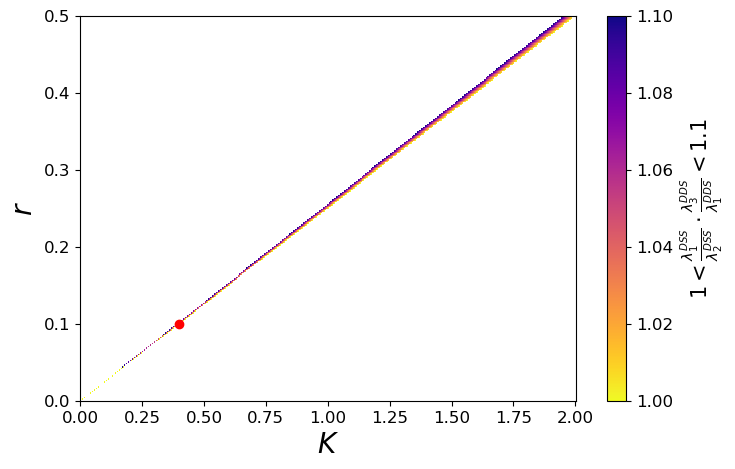

([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5], PyObject[PyObject Text(0, 0.0, '0.0'), PyObject Text(0, 0.1, '0.1'), PyObject Text(0, 0.2, '0.2'), PyObject Text(0, 0.30000000000000004, '0.3'), PyObject Text(0, 0.4, '0.4'), PyObject Text(0, 0.5, '0.5')])

In [96]:
#plt.style.use("dark_background")

fig = figure(figsize=(8, 5))
cmap = plt.cm.plasma_r

pcm = plt.pcolormesh(KK, RR, accepted_points', cmap = cmap, shading="nearest", vmin=minimum(1), vmax=maximum(1.1))
#colorbar(pcm, label = L"min(-\frac{\lambda_1^{DSS}}{\lambda_2^{DSS}}, -\frac{\lambda_3^{DDS}}{\lambda_1^{DDS}})")
cbar = colorbar(pcm)
cbar.set_label(label = L"1 < \frac{\lambda_1^{DSS}}{\lambda_2^{DSS}} \cdot \frac{\lambda_3^{DDS}}{\lambda_1^{DDS}} < 1.1", size=15) 
cbar.ax.tick_params(labelsize=12) 

scatter(0.4, 0.1, color = "red")

fig.gca().set_ylim([0, 0.5])

plt.xlabel(L"$K$", fontsize=20)
plt.ylabel(L"$r$", fontsize=20)

plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

#plt.title(L"$a_2 = \frac{\pi}{2}, a_4 = \pi$")

#plt.style.use("default")

---

# Расчет карты

In [55]:
λs_s = zeros(1, Resolution, length(Eps_mesh), 7)

@time begin
    for ((i, a2_cur), (j, a4_cur)) = [[p, m] for p in enumerate(A2) for m in enumerate(A4)]
        if accepted_points[i, j] == 1
            @time begin
                
                SP = SystemParameters(K, a2_cur, a4_cur, r, Eps_mesh)
                λs_s[i, j, :, :] .= LEs_execution(SP, NP)

                println("Cell №: ", i, " ", j)
            end
        end
    end 
end

Cell №: 1 1
 63.774100 seconds (4.01 M allocations: 1.372 GiB, 0.44% gc time)
Cell №: 1 2
 63.360757 seconds (4.01 M allocations: 1.372 GiB, 0.44% gc time)
Cell №: 1 3
 63.364150 seconds (4.01 M allocations: 1.372 GiB, 0.40% gc time)
Cell №: 1 4
 62.395912 seconds (4.01 M allocations: 1.372 GiB, 0.49% gc time)
Cell №: 1 5
 63.136654 seconds (4.01 M allocations: 1.372 GiB, 0.43% gc time)
Cell №: 1 6
 61.081606 seconds (4.01 M allocations: 1.372 GiB, 0.45% gc time)
Cell №: 1 7
 62.079602 seconds (4.01 M allocations: 1.372 GiB, 0.44% gc time)
Cell №: 1 8
 69.933990 seconds (4.01 M allocations: 1.372 GiB, 0.40% gc time)
Cell №: 1 9
 69.142662 seconds (4.01 M allocations: 1.372 GiB, 0.41% gc time)
Cell №: 1 10
 70.701065 seconds (4.01 M allocations: 1.372 GiB, 0.37% gc time)
Cell №: 1 11
 63.457879 seconds (4.01 M allocations: 1.372 GiB, 0.47% gc time)
Cell №: 1 12
 64.765897 seconds (4.01 M allocations: 1.372 GiB, 0.43% gc time)
Cell №: 1 13
 69.221874 seconds (4.01 M allocations: 1.372 Gi

---

# Сохранение и загрузка карт значений Ляпуновских показателей

In [56]:
save(string(NP.alg) * "_" * string(NP.System)* string(K) * "_" * string(r) * "_LLE_λs_s_2.jld", "λs_s", λs_s)

In [20]:
Resolution = 50
Eps_Length = 15

Rate_Arr = zeros(Resolution, Resolution);

# Параметры системы
K = 0.4

A2 = range(pi/2 - pi/18, pi/2 + pi/18, length = Resolution)
A4 = range(pi - pi/8, pi + pi/8, length = Resolution)

r = 0.1

Eps_mesh = exp10.(range(-10, -3, length=Eps_Length))

λs_s = load("DP8()_BS_Cos_Sys0.4_0.1_LLE_λs_s.jld")["λs_s"];

In [39]:
Resolution = 50
Eps_Length = 9

# Параметры системы
K = 0.4

A2 = range(pi/2, pi/2 + pi/16, step = pi/(16 * Resolution))
A4 = range(pi, pi + pi/8, step = pi/(8 * Resolution))

r = 0.1

Eps_mesh = exp10.(range(-7, -3, length=Eps_Length))

λs_s = load("DP8()_BS_Cos_Sys0.4_0.1_LLE_λs_s_1.jld")["λs_s"];

In [44]:
Resolution = 200
Eps_Length = 10

# Параметры системы
K = 0.4

A2 = pi/2
A4 = range(pi, pi + pi/16, length = Resolution)

r = 0.1

Eps_mesh = exp10.(range(-8, -5, length=Eps_Length))

λs_s = load("DP8()_BS_Cos_Sys0.4_0.1_LLE_λs_s_2.jld")["λs_s"];

---

# Различная интерпретация полученных результатов

In [21]:
RateArr = zeros(Resolution, Resolution, 3)
RA_Border = 9
RA_POI = []

for (i, j) = [[p, m] for p in 1:Resolution for m in 1:Resolution]
    λs = λs_s[i, j, :, 1:6]
    if any(i -> i != 0, λs[:, :])
        
        for k = 1 : length(Eps_mesh)
            RateVal = 0
            if any(i -> abs(i) < 1e-3, λs[k, :])
                RateVal = RateVal + 1
                if any(i -> i > 1e-2, λs[k, :])
                    RateVal = RateVal + 1
                end
            end
            RateArr[i, j, RateVal + 1] += 1
        end
        
        #if RateVal >= RA_Border
        #    push!(RA_POI, [i, j])
        #end
    else
        RateArr[i, j, :] .= NaN
    end
end

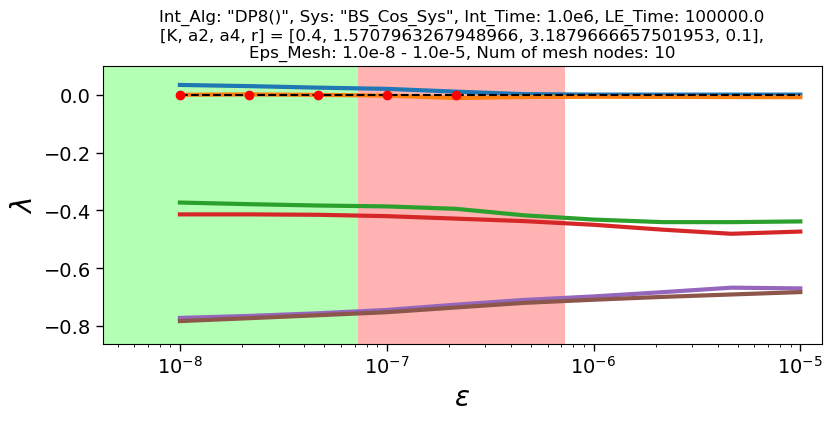

In [62]:
for (i, j) = RA_POI
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

In [23]:
λs_s[1, 48, :, :]

10×7 Matrix{Float64}:
 0.0334965    -0.000448891  -0.372607  -0.413561  -0.771012  -0.782009  0.0
 0.0294416     0.000780573  -0.378232  -0.413485  -0.764201  -0.771991  0.0
 0.0241836    -0.000724775  -0.382886  -0.414881  -0.755067  -0.761795  0.0
 0.0199846    -0.00342338   -0.38595   -0.419592  -0.743532  -0.751337  0.0
 0.0103962    -0.0116905    -0.394233  -0.428107  -0.72532   -0.734984  0.0
 0.00169155   -0.00810338   -0.41681   -0.436822  -0.708866  -0.718982  1.0
 0.000141131  -0.00743951   -0.431429  -0.449363  -0.696857  -0.708231  1.0
 4.99985e-5   -0.00769074   -0.440206  -0.466245  -0.68216   -0.698426  1.0
 7.92128e-5   -0.00827954   -0.440283  -0.480474  -0.666601  -0.690104  1.0
 0.000103531  -0.00888795   -0.437812  -0.472788  -0.669111  -0.681878  1.0

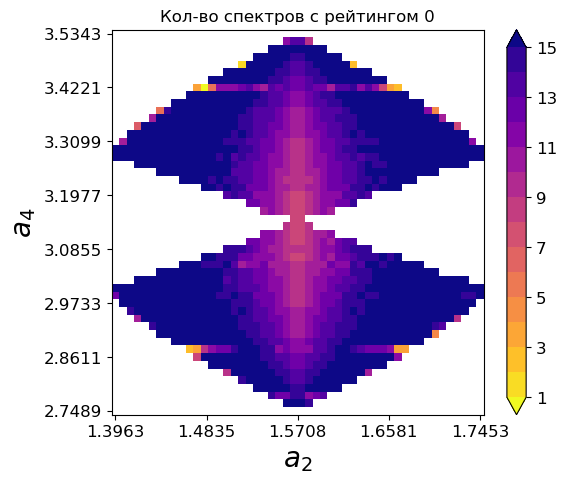

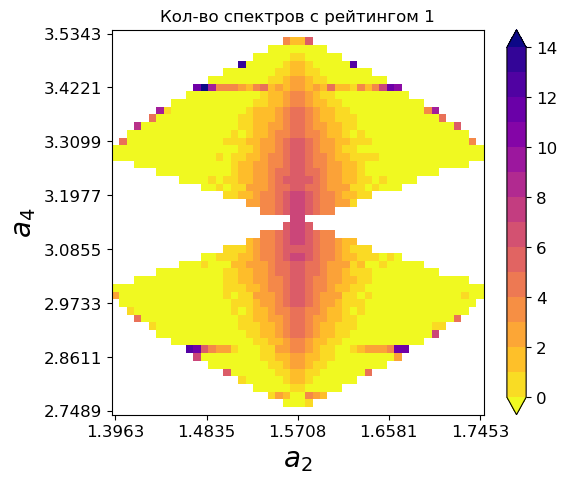

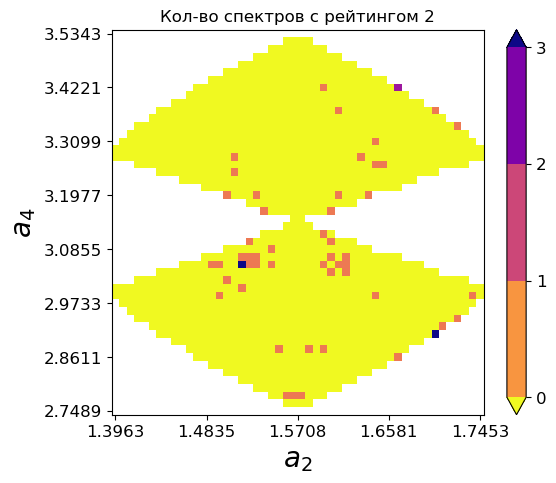

In [22]:
Plot_map(A2, A4, RateArr[: , :, 1], "Кол-во спектров с рейтингом 0", RA_POI)
Plot_map(A2, A4, RateArr[: , :, 2], "Кол-во спектров с рейтингом 1", RA_POI)
Plot_map(A2, A4, RateArr[: , :, 3], "Кол-во спектров с рейтингом 2", RA_POI)

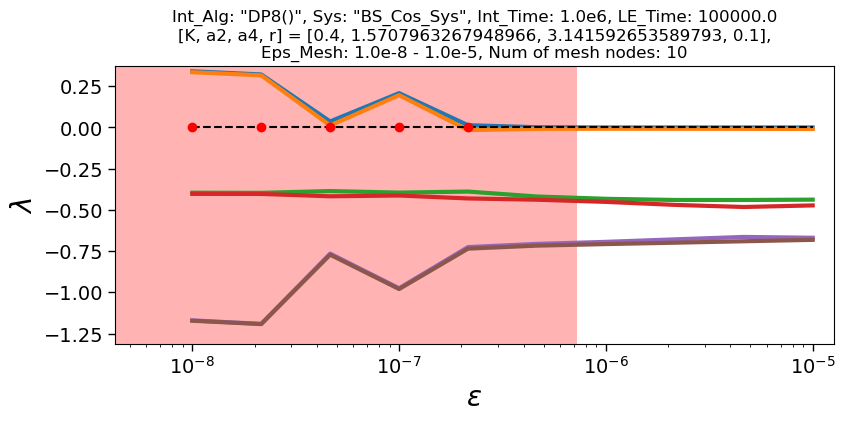

In [42]:
SP = SystemParameters(K, A2[1], A4[1], r, Eps_mesh)
fig = LLE_plot(λs_s[1, 1, :, :], SP, NP);

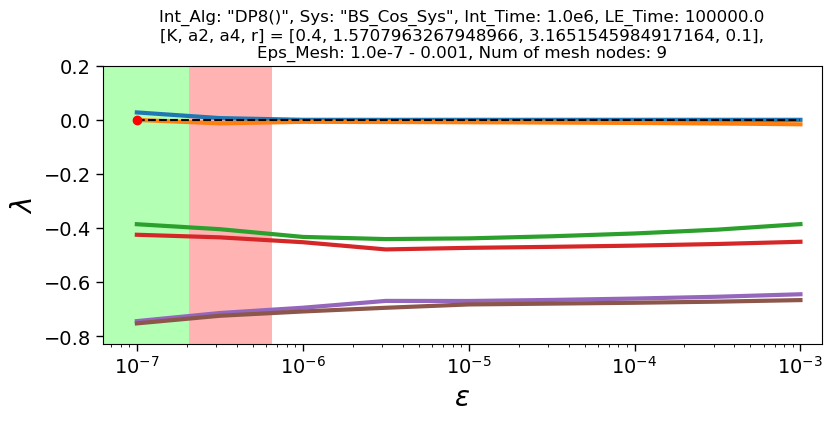

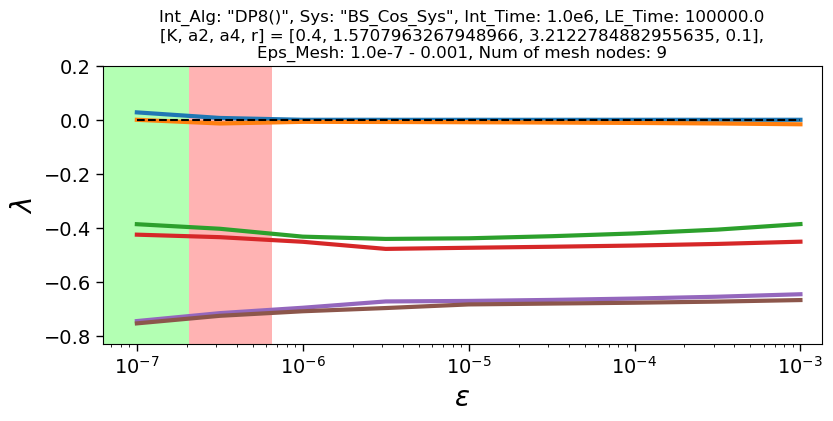

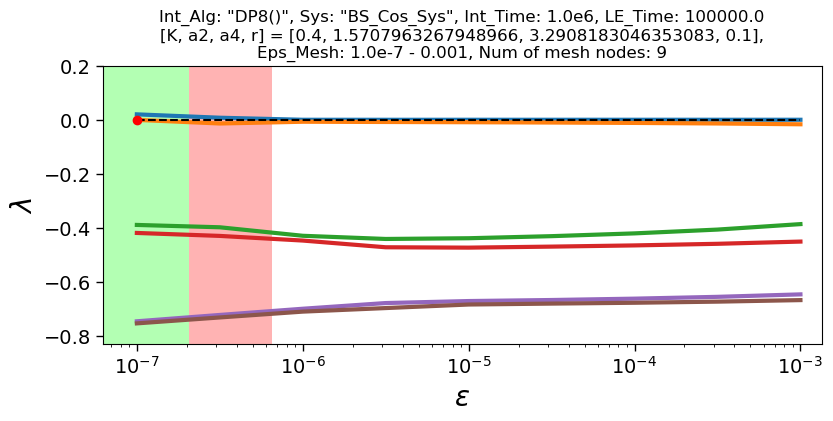

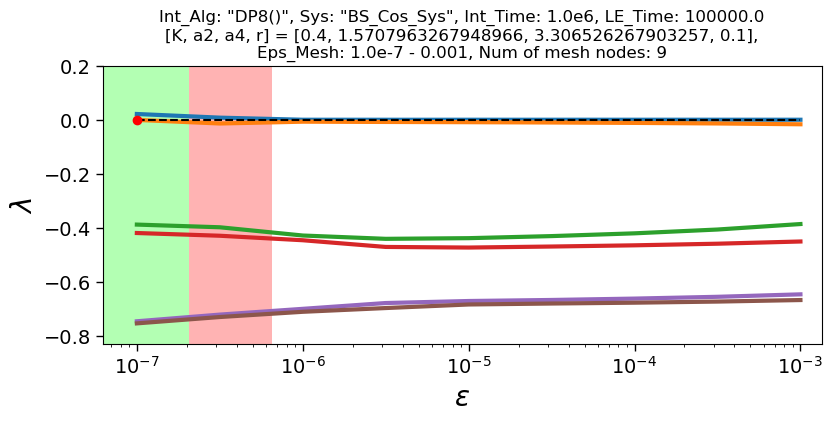

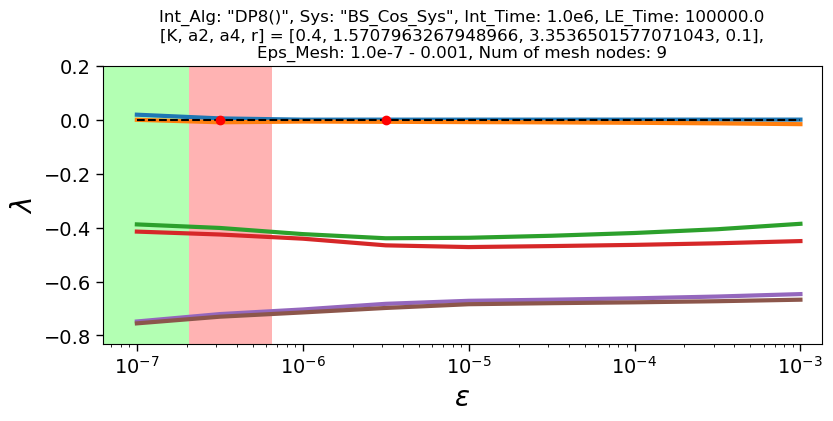

In [44]:
for (i, j) = RA_POI
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

In [34]:
#for k = 1 : length(RA_POI)
    
    SP_cur = SystemParameters(K, A2[RA_POI[2][1]], A4[RA_POI[2][2]], r, exp10.(range(-7, -3, length=25)))
    NP_cur = NumericParameters(System, alg, startPt, Int_Time, 5e5, 2e4, dt, abstol, reltol, maxiters)
    λs = LEs_execution(SP_cur, NP_cur)
#end 

25×7 Matrix{Float64}:
 0.0168024    -0.00659992  -0.382222  -0.414188  -0.746761  -0.754058  1.0
 0.0144123    -0.00764969  -0.384302  -0.41547   -0.741429  -0.749032  1.0
 0.0119462    -0.00858835  -0.386386  -0.417119  -0.736183  -0.744289  1.0
 0.00793379   -0.00916662  -0.391645  -0.419466  -0.72887   -0.737755  1.0
 0.00459703   -0.00945636  -0.398196  -0.423251  -0.721281  -0.730795  1.0
 0.00162331   -0.00817528  -0.40745   -0.42765   -0.713866  -0.724361  1.0
 0.000408043  -0.00761689  -0.415376  -0.433472  -0.706956  -0.717839  1.0
 1.27641e-5   -0.0074531   -0.422017  -0.440674  -0.700506  -0.712429  1.0
 5.17799e-6   -0.00779063  -0.427844  -0.448578  -0.694024  -0.707073  1.0
 1.56941e-5   -0.00809045  -0.433415  -0.456544  -0.687315  -0.701568  1.0
 3.36707e-5   -0.00838526  -0.438431  -0.46473   -0.679839  -0.695052  1.0
 1.99552e-5   -0.00868198  -0.440208  -0.47079   -0.675405  -0.689561  1.0
 2.43402e-5   -0.00900034  -0.437864  -0.472964  -0.673125  -0.68685   1.0
 2.

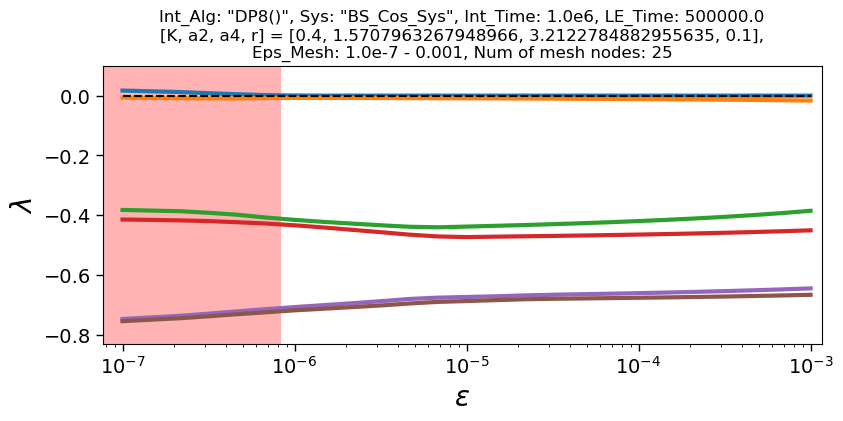

In [37]:
LLE_plot(λs, SP_cur, NP_cur);

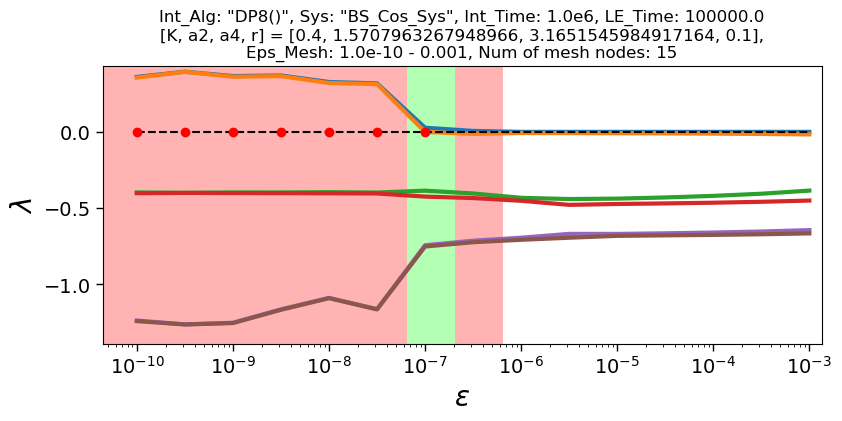

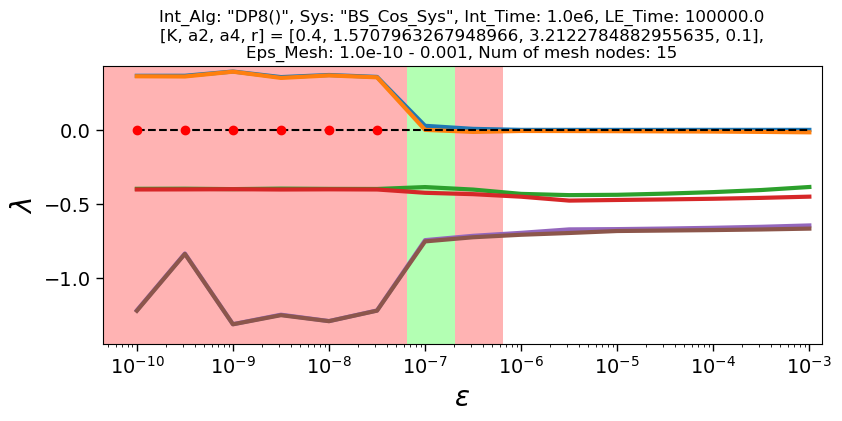

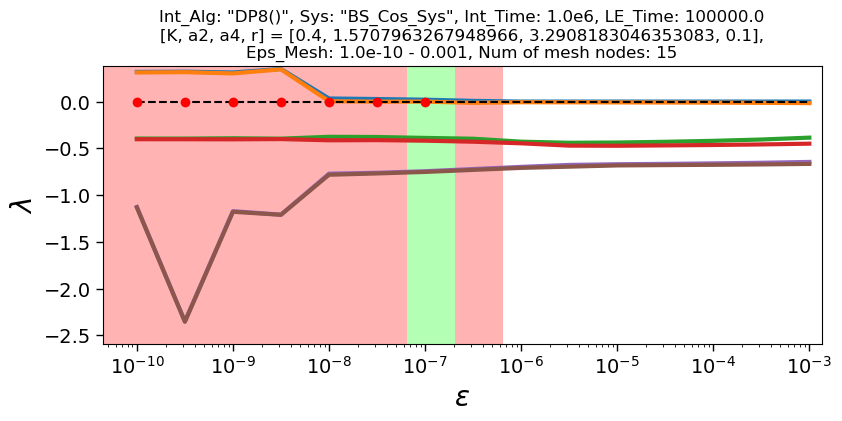

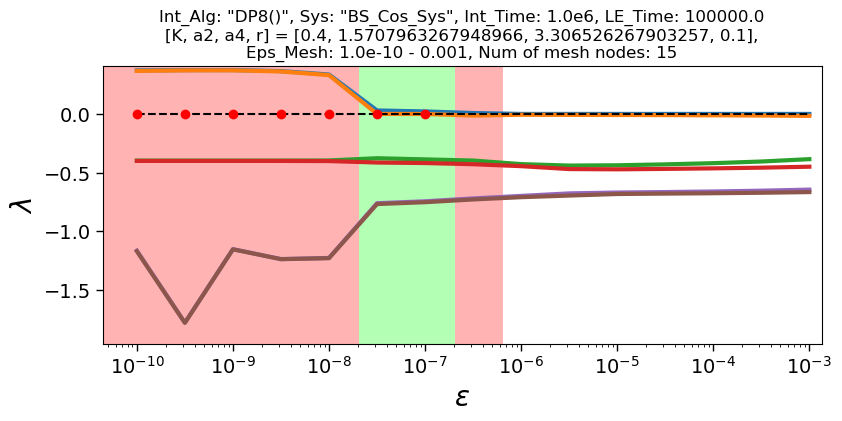

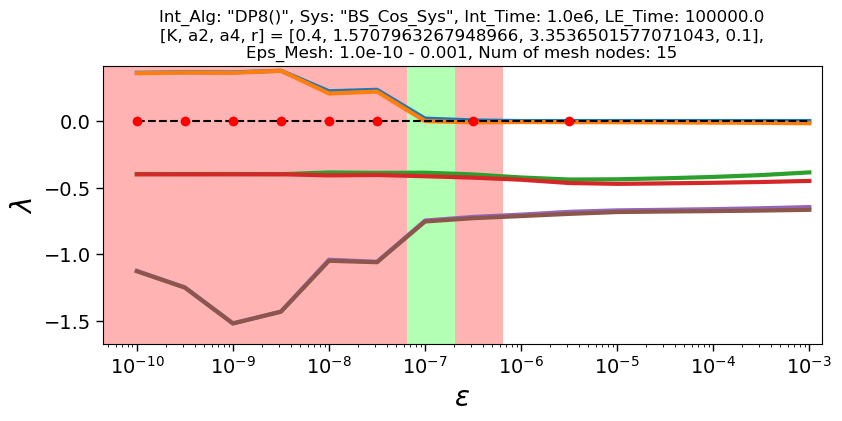

In [72]:
for k = 1 : length(RA_POI)
    
    SP_cur = SystemParameters(K, A2[RA_POI[k][1]], A4[RA_POI[k][2]], r, exp10.(range(-10, -3, length=15)))
    NP_cur = NumericParameters(System, alg, startPt, Int_Time, LE_Time, Ttr, dt, abstol, reltol, maxiters)
    λs = λs_cur[k, :, :]
    LLE_plot(λs, SP_cur, NP_cur)
end 

---

In [24]:
MaxRateArr = zeros(Resolution, Resolution)
MRA_Border = 2
MRA_POI = []
#MRA_POI = [[A2[10], A4[15]], [A2[25], A4[18]], [A2[19], A4[20]]]

for (i, j) = [[p, m] for p in 1:Resolution for m in 1:Resolution]
    λs = λs_s[i, j, :, 1:6]
    if any(i -> i != 0, λs[:, :])
        MaxRateVal = zeros(Eps_Length)
        for k = 1 : length(Eps_mesh)
            RateVal = 0
            if any(i -> abs(i) < 1e-3, λs[k, :])
                RateVal = RateVal + 1
                if any(i -> i > 1e-2, λs[k, :])
                    RateVal = RateVal + 1
                end
            end
            MaxRateVal[k] = RateVal
        end
        MaxRateArr[i, j] = maximum(MaxRateVal)
        if MaxRateArr[i, j] >= MRA_Border
            push!(MRA_POI, [i, j])
        end
    else
        MaxRateArr[i, j] = NaN
    end
    
end

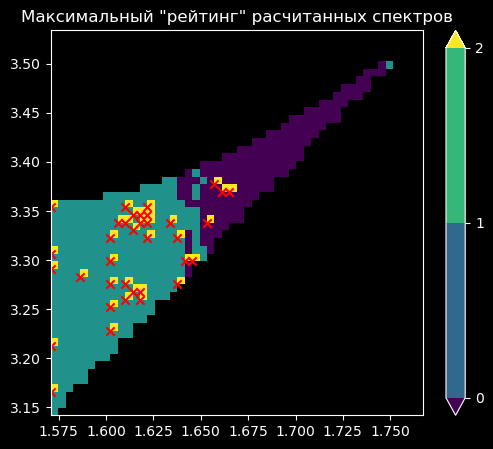

In [46]:
Plot_map(A2, A4, MaxRateArr, "Максимальный \"рейтинг\" расчитанных спектров", MRA_POI)

#scatter(A2[10], A4[15], color = "red", marker = "x")
#scatter(A2[25], A4[18], color = "blue", marker = "x")
#scatter(A2[19], A4[20], color = "green", marker = "x")

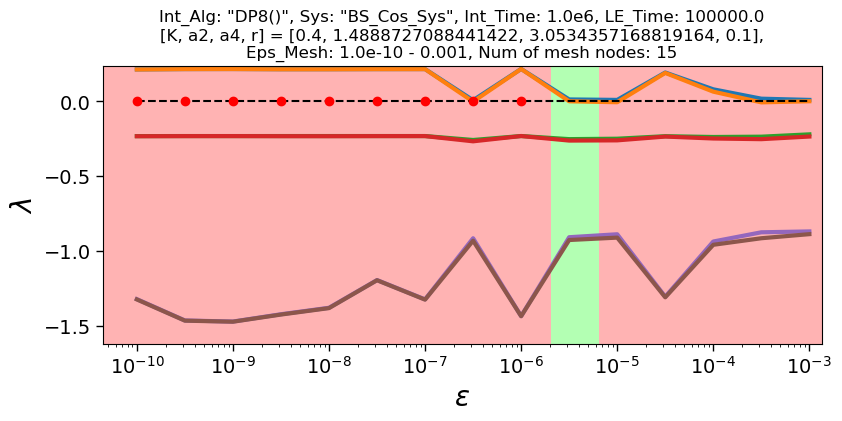

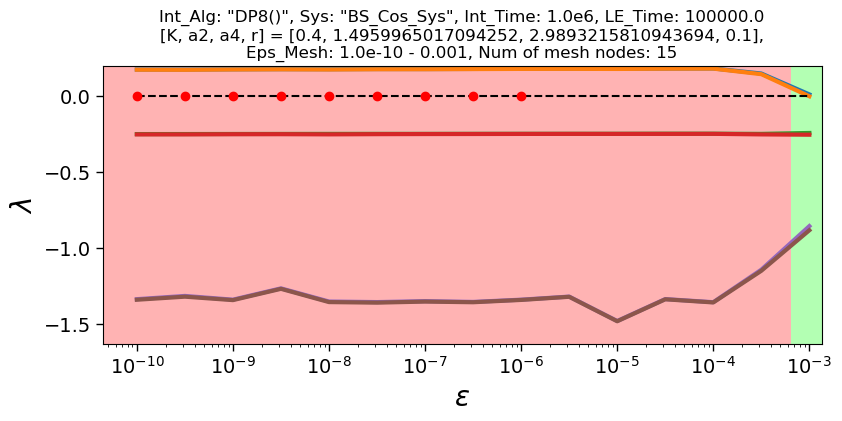

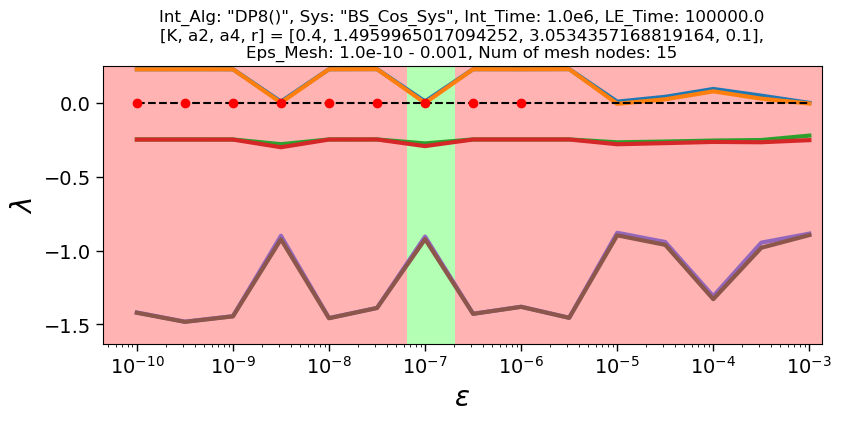

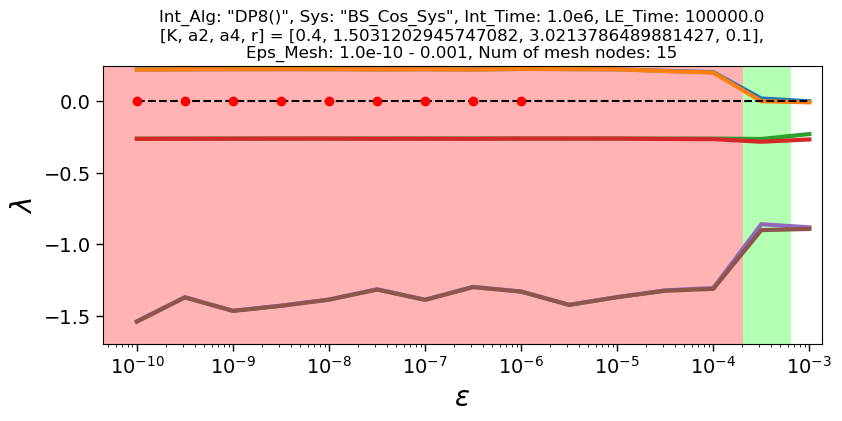

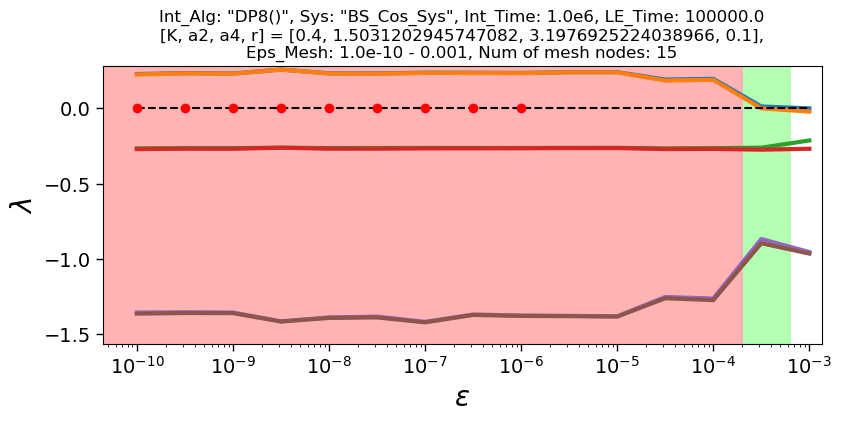

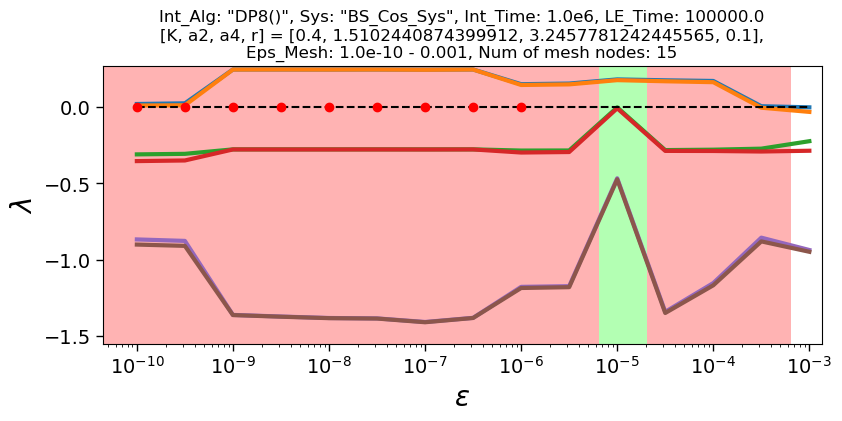

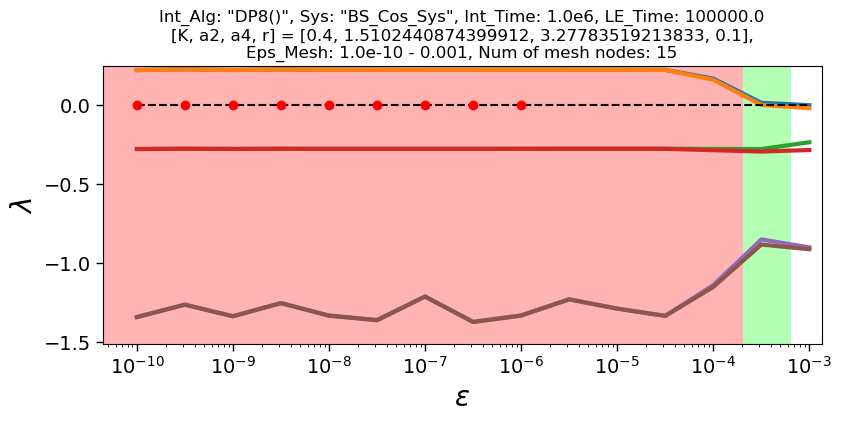

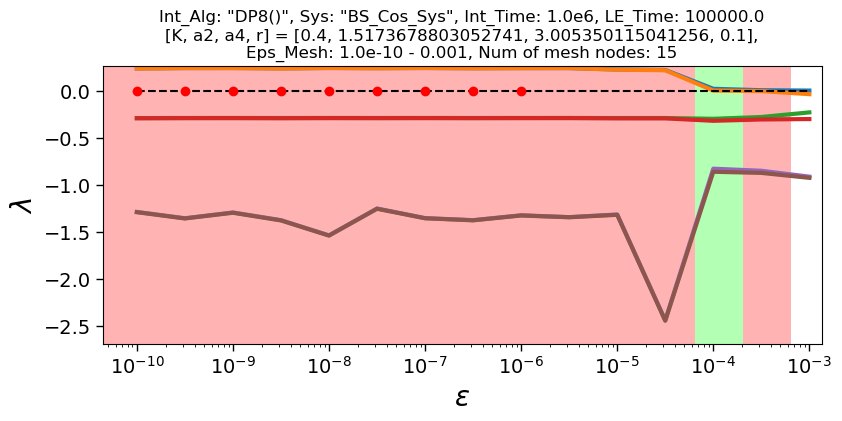

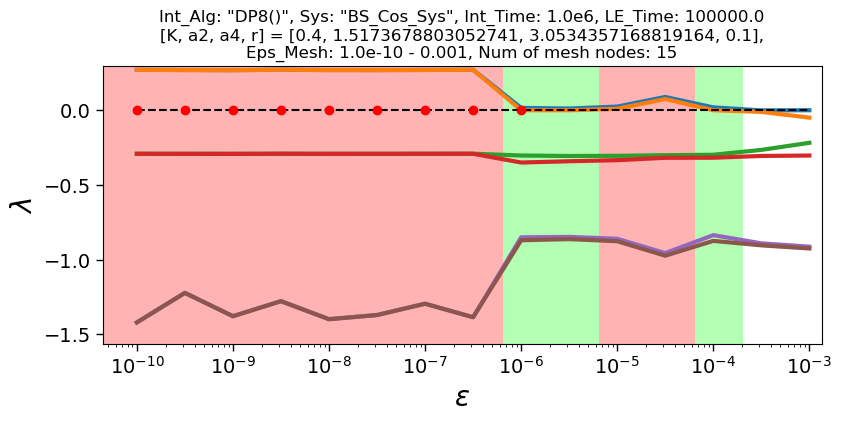

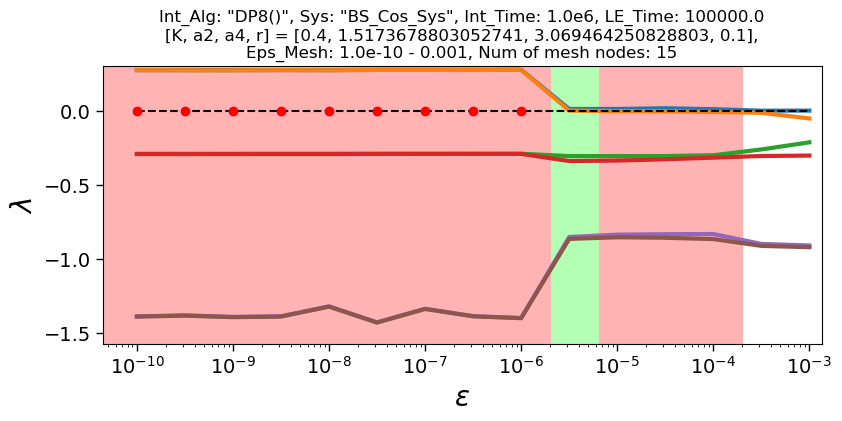

In [36]:
for (i, j) = MRA_POI[1 : 10]
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

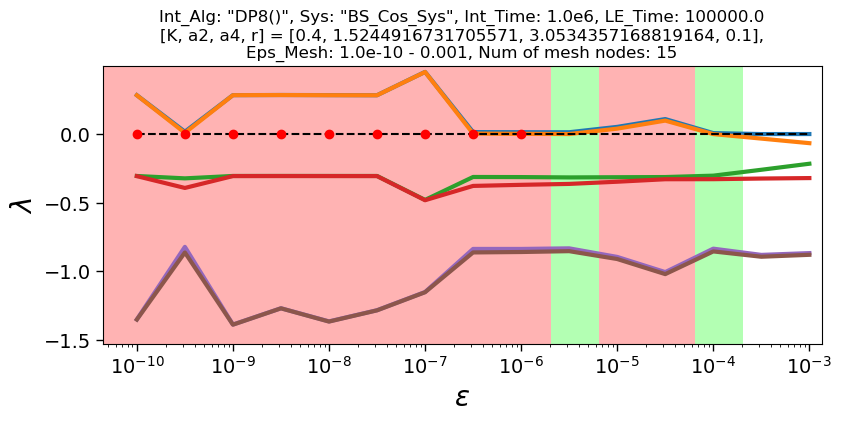

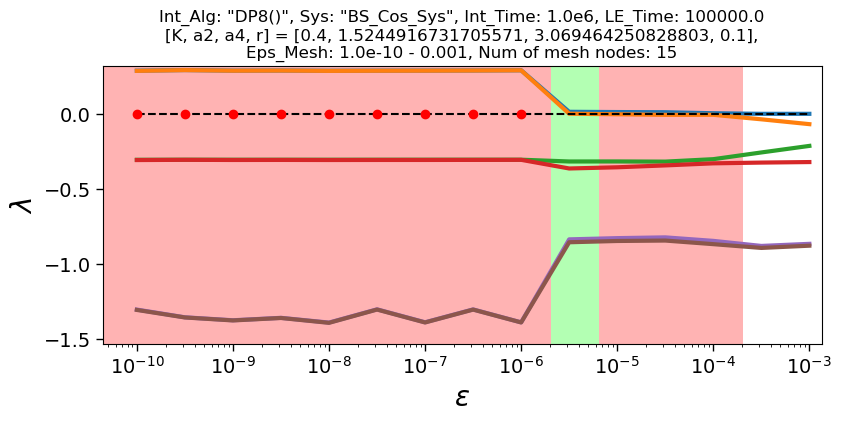

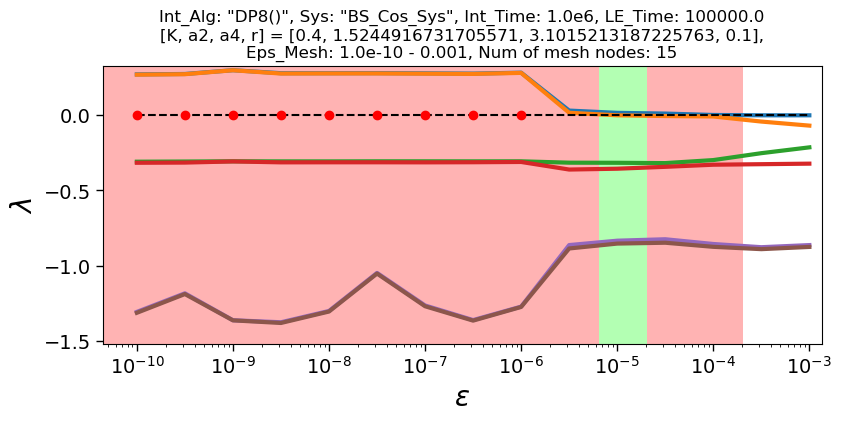

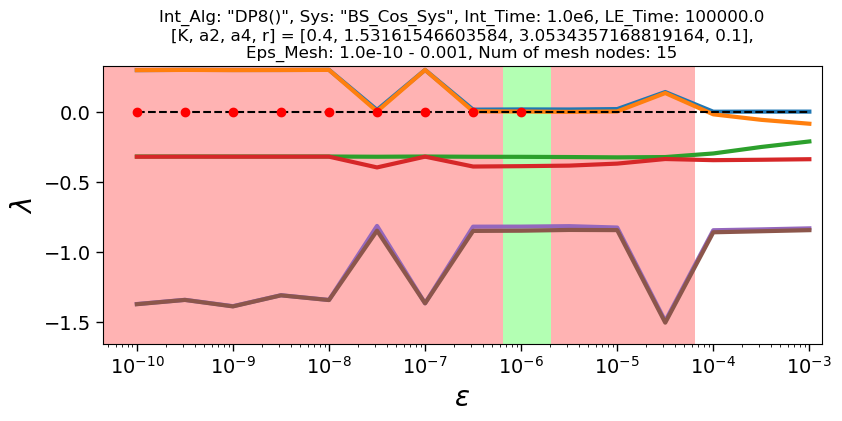

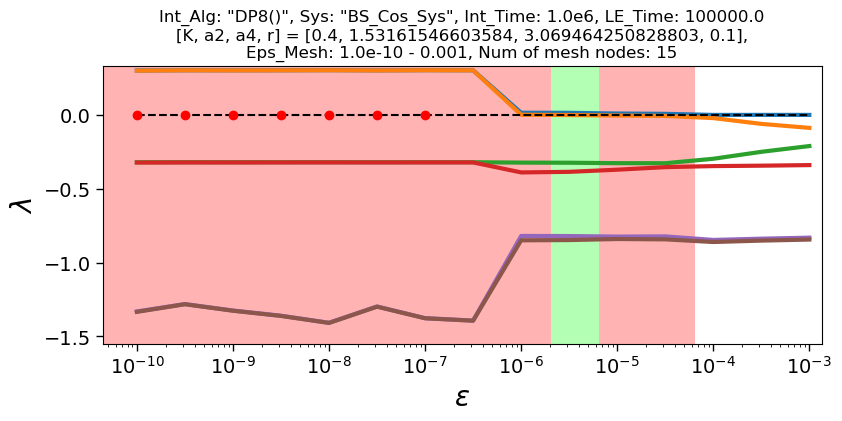

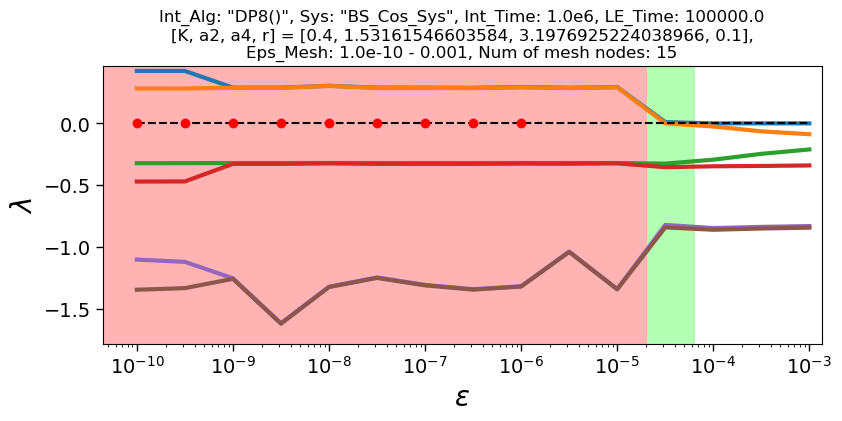

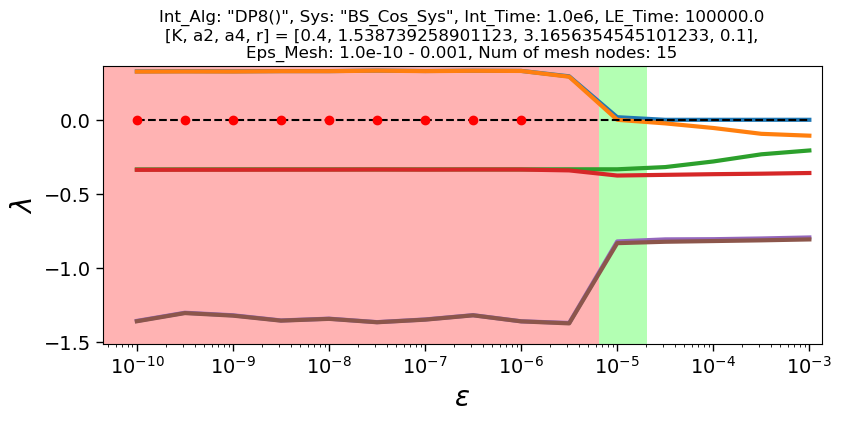

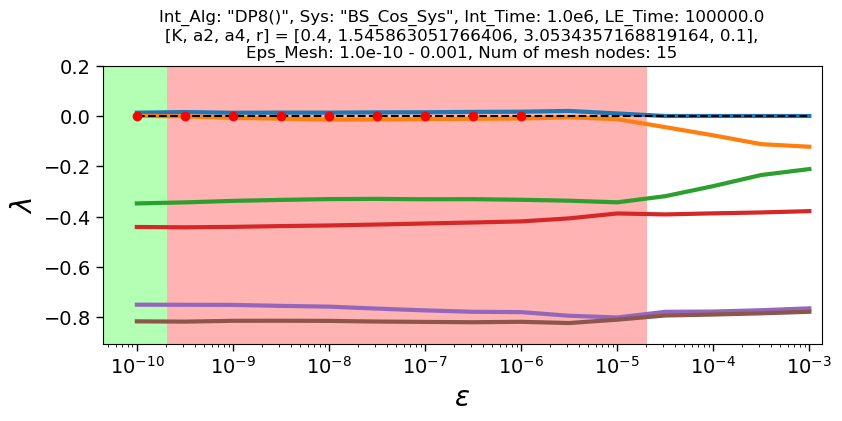

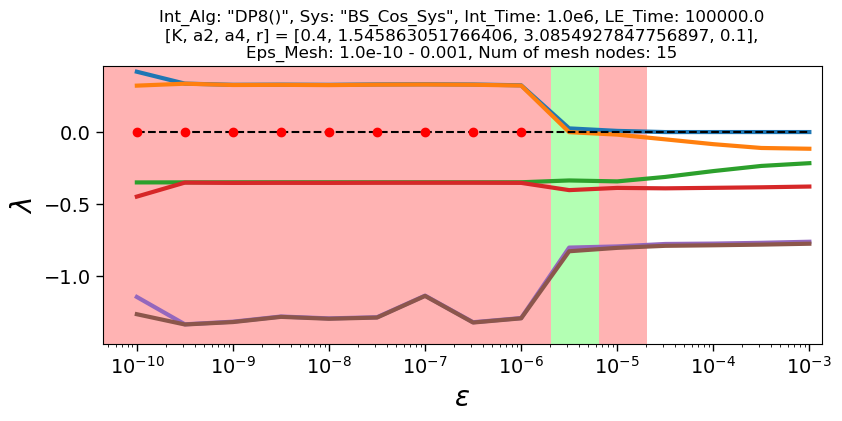

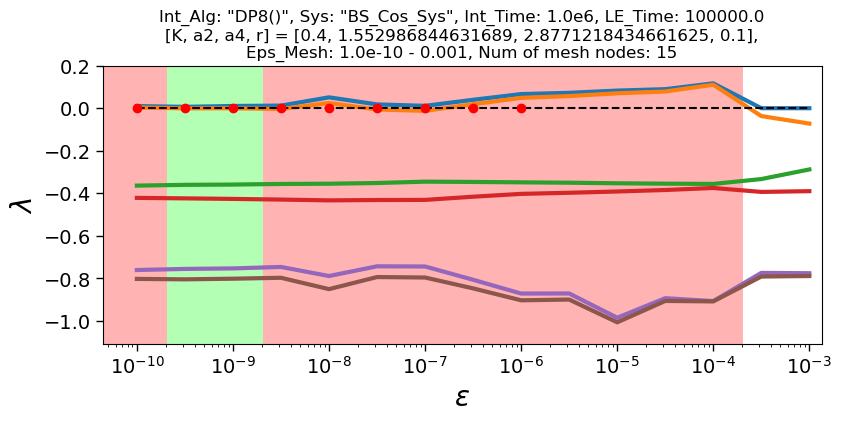

In [37]:
for (i, j) = MRA_POI[11 : 20]
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

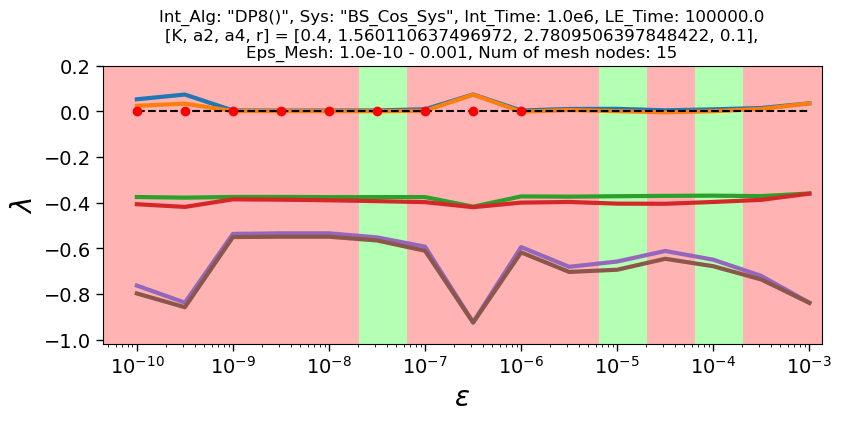

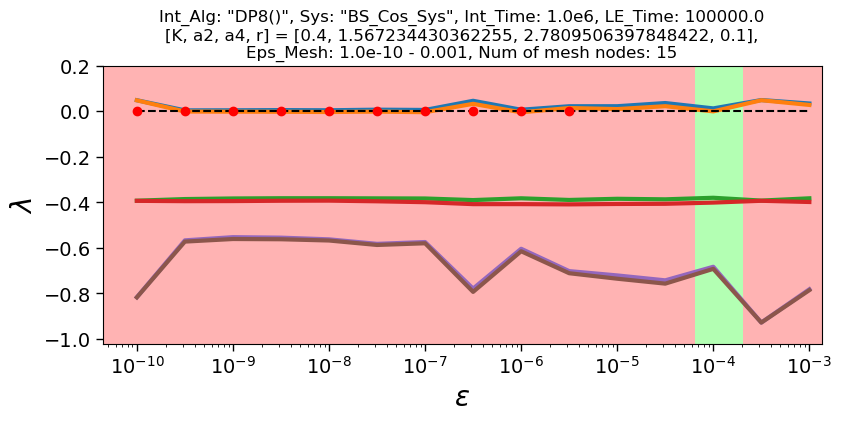

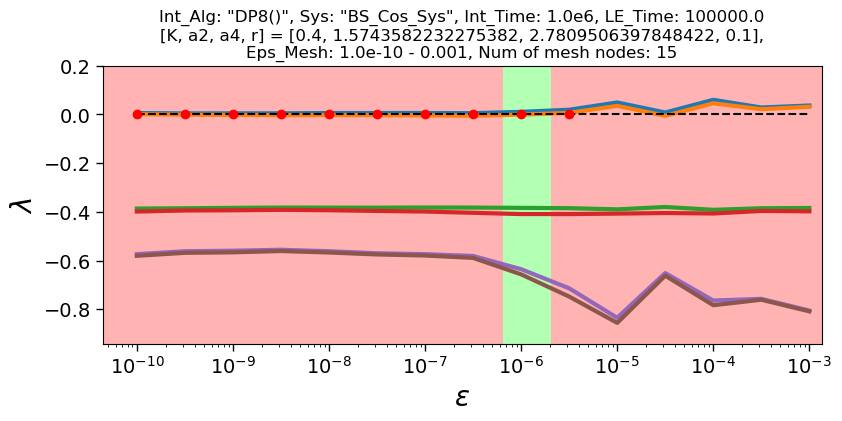

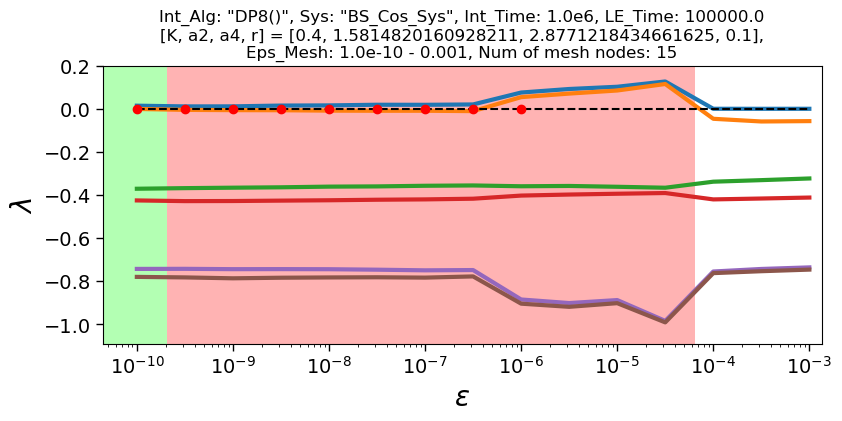

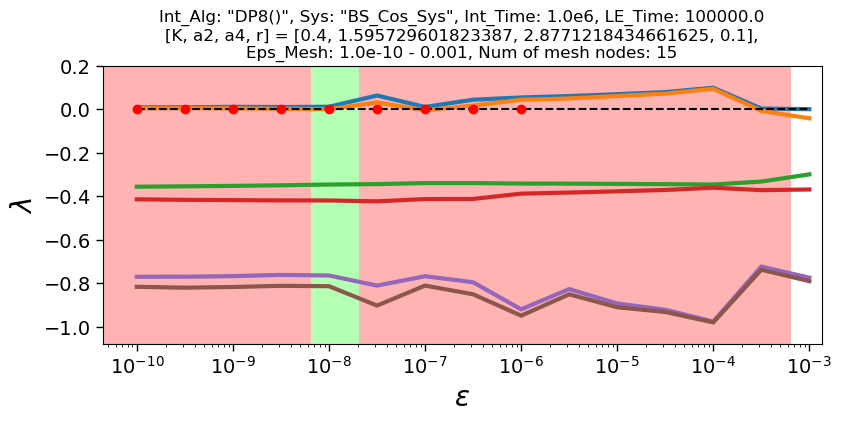

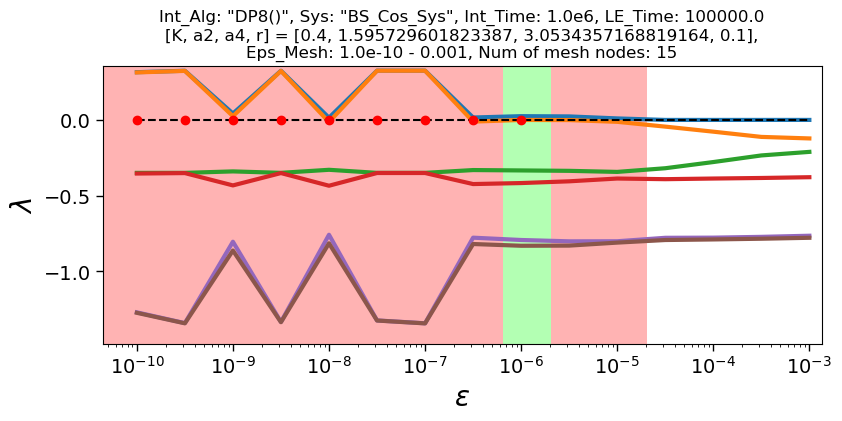

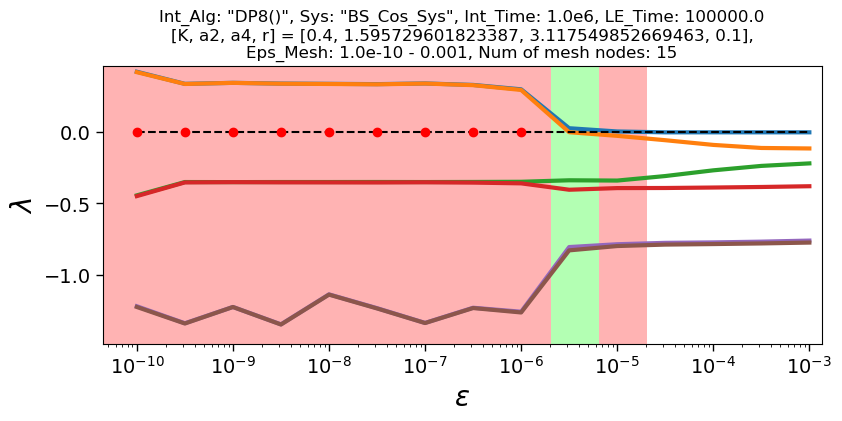

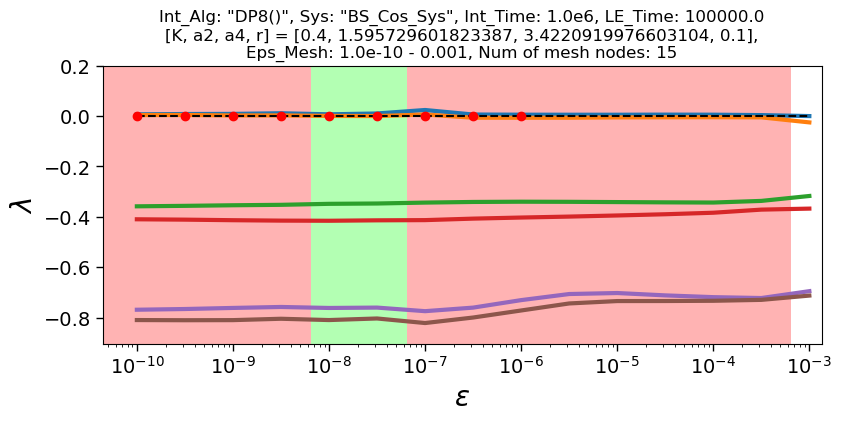

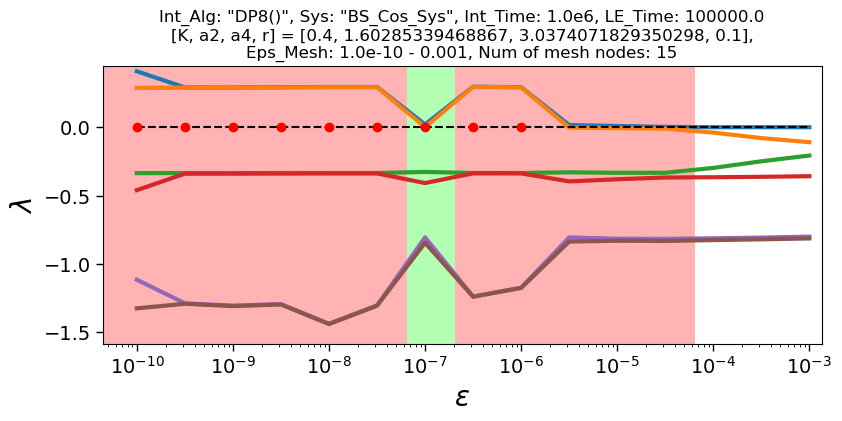

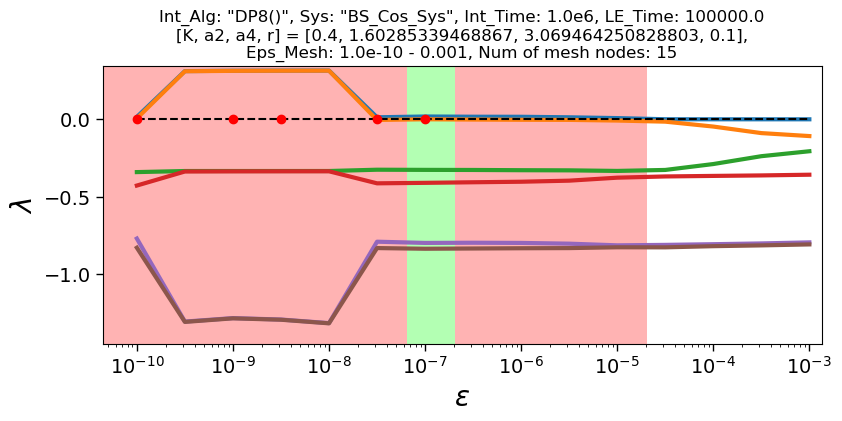

In [38]:
for (i, j) = MRA_POI[21 : 30]
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

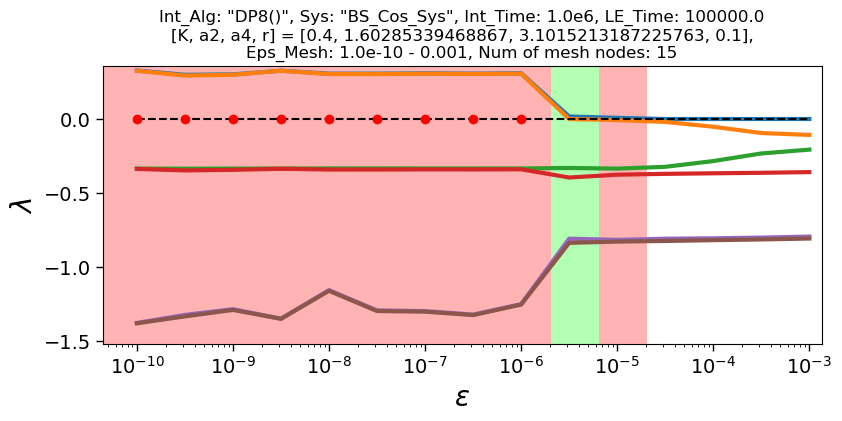

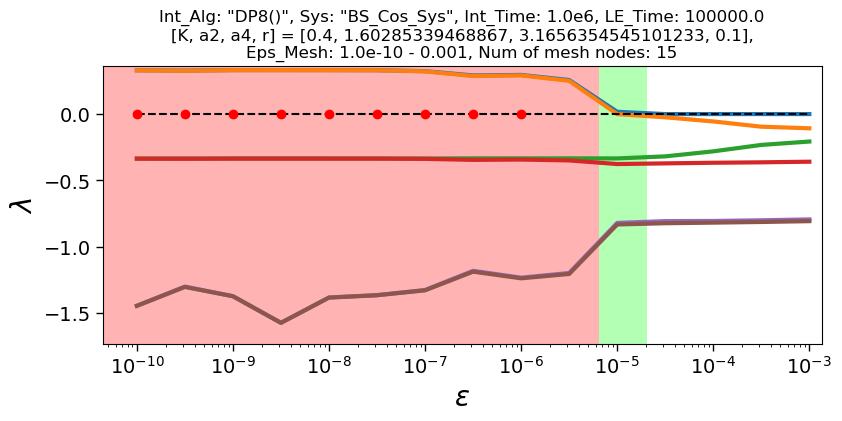

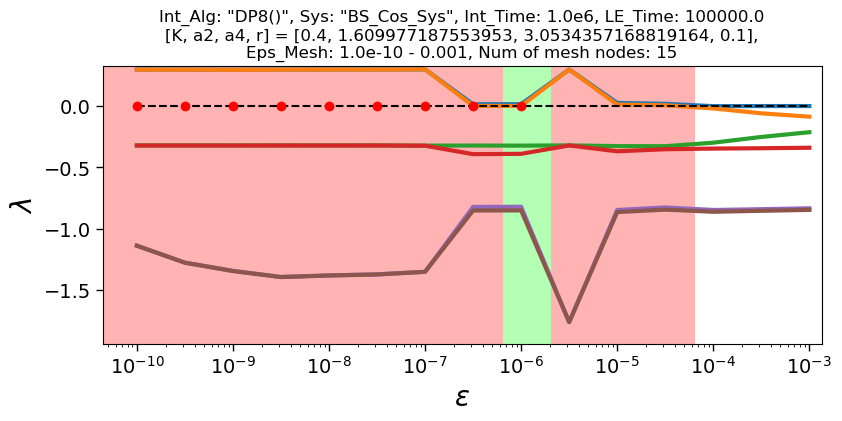

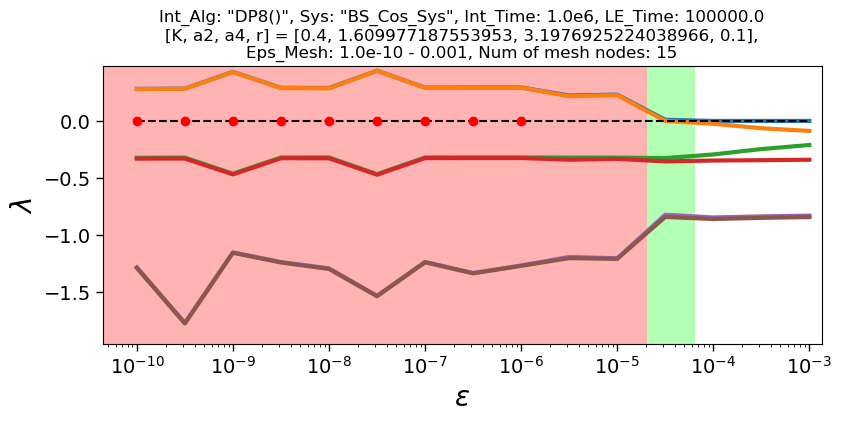

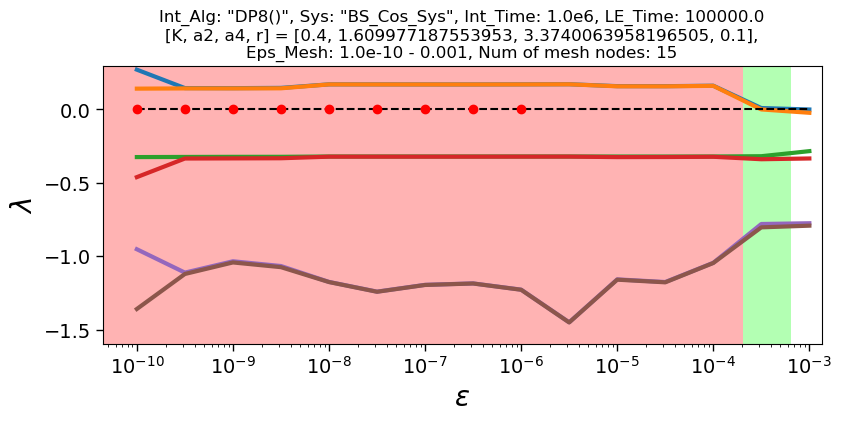

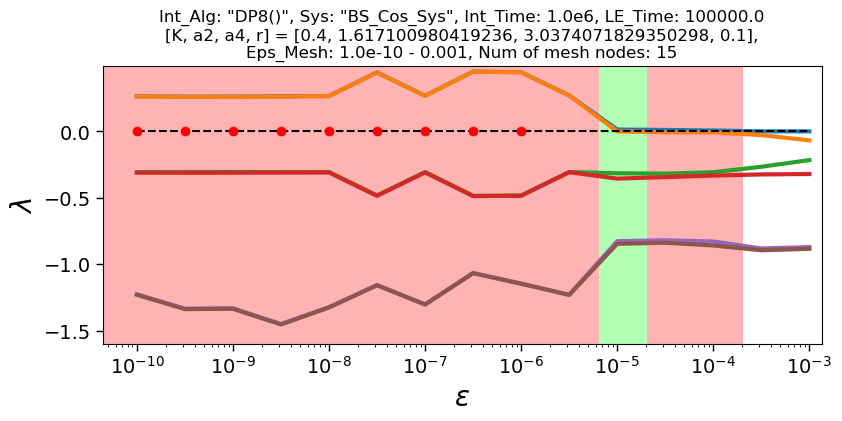

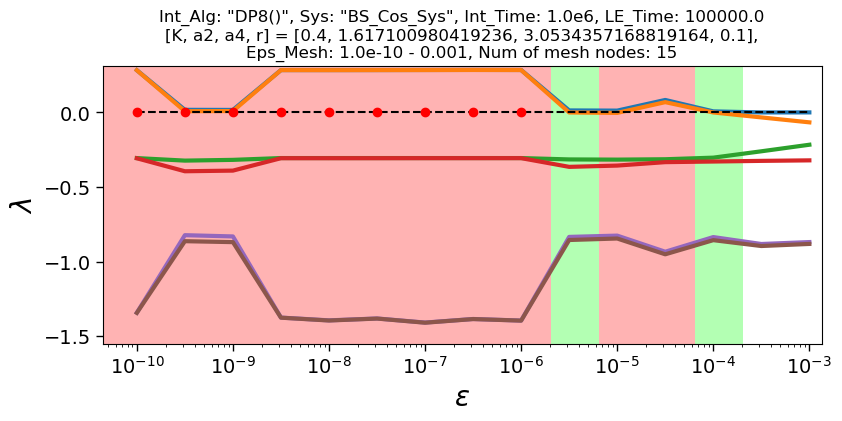

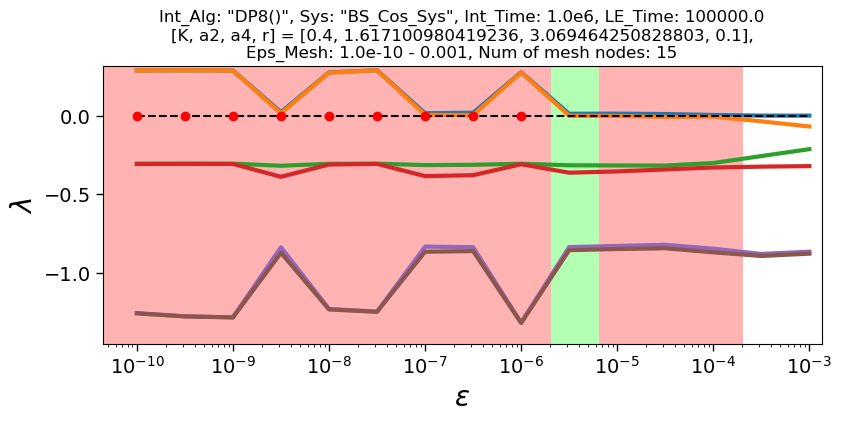

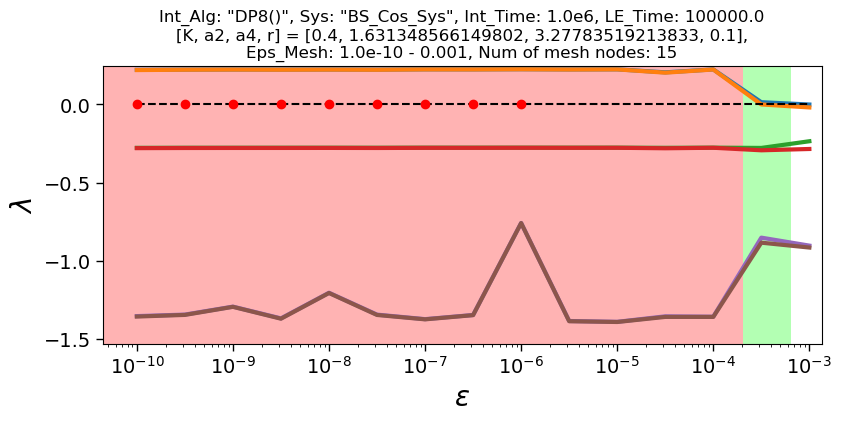

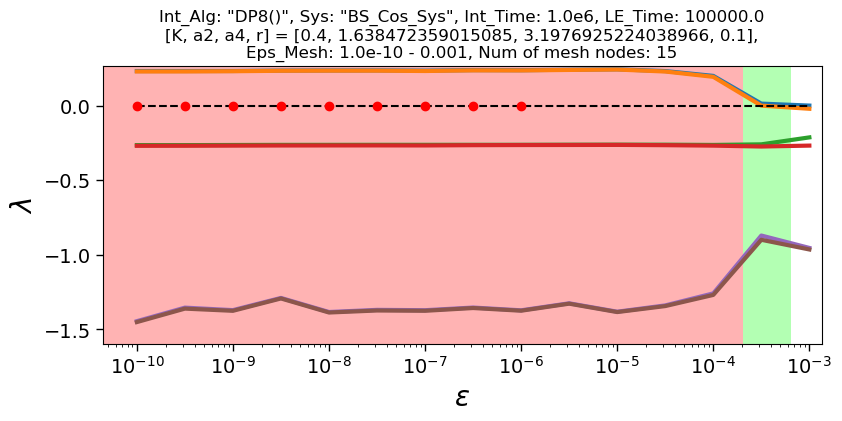

In [39]:
for (i, j) = MRA_POI[31 : 40]
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

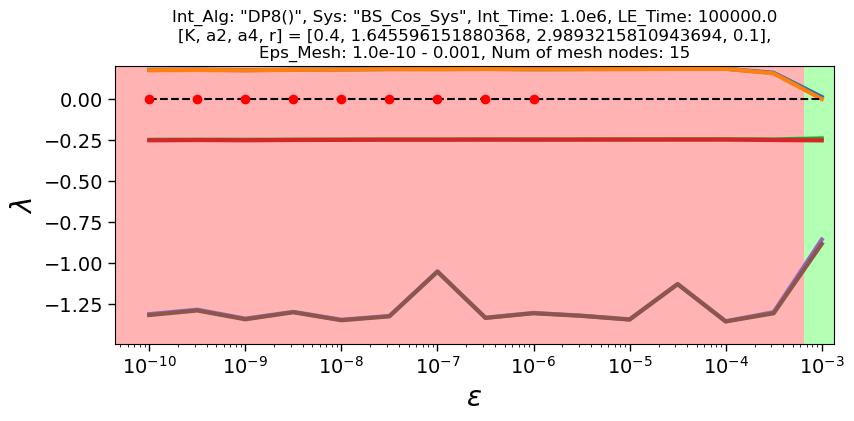

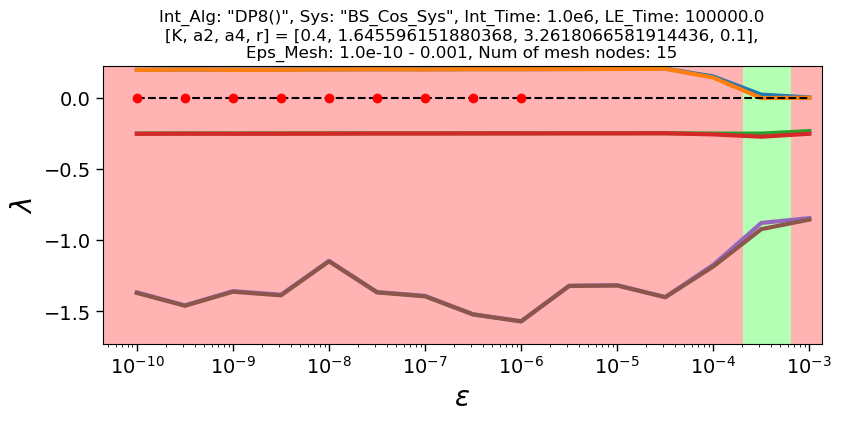

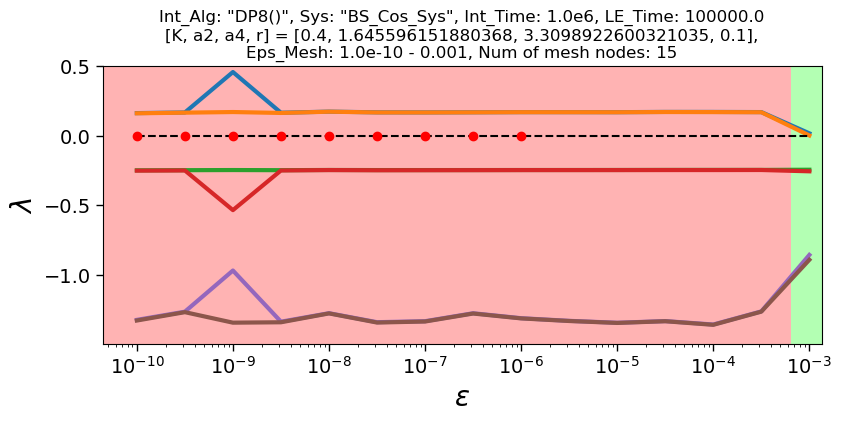

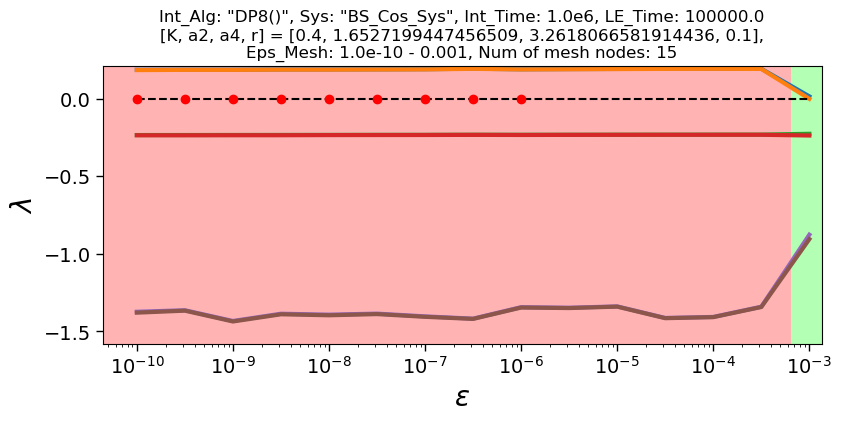

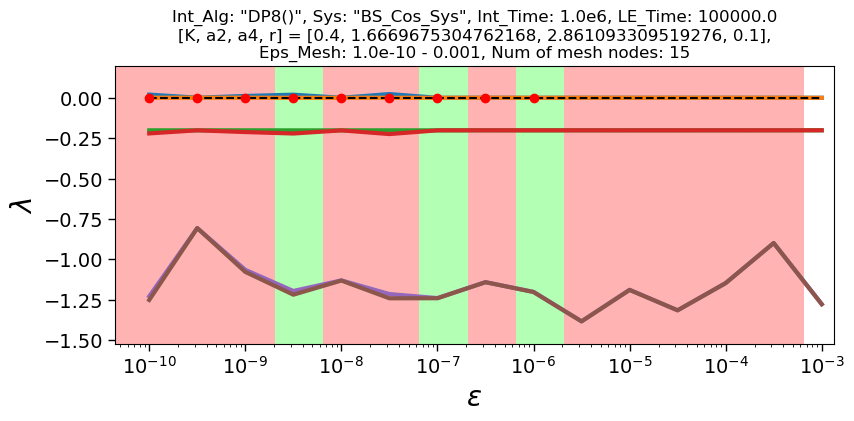

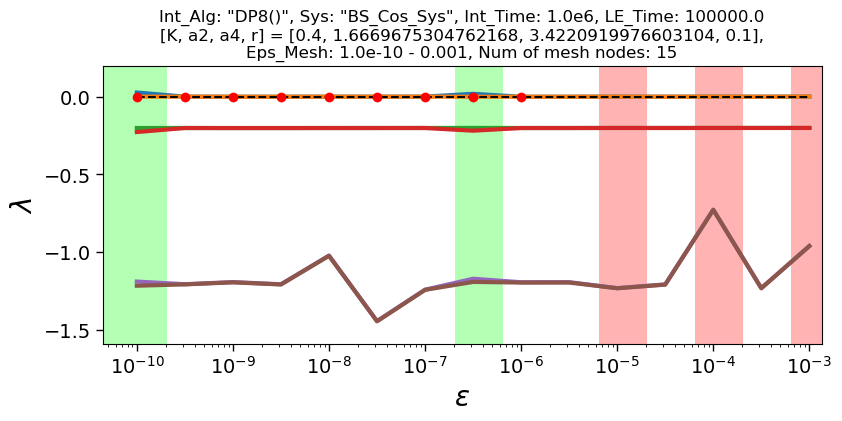

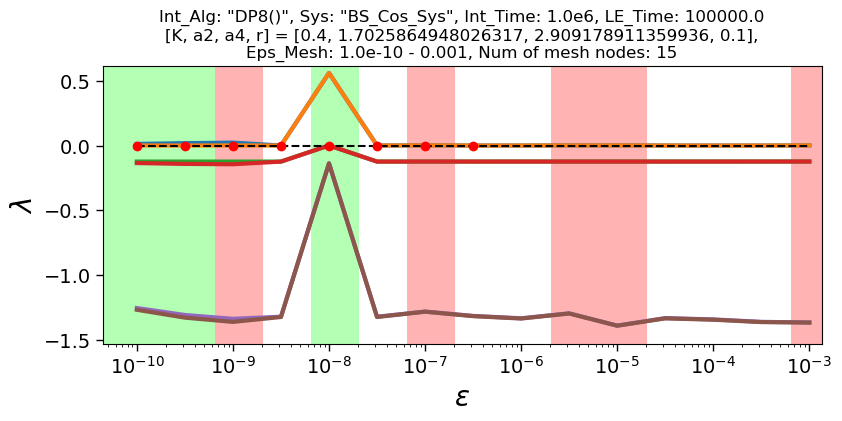

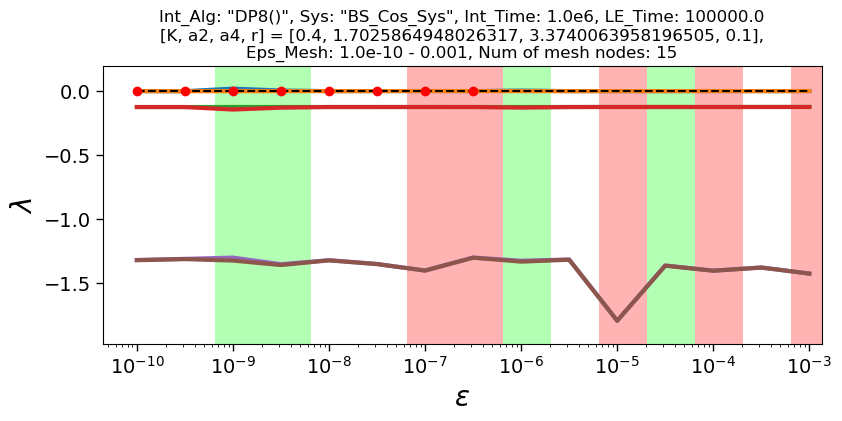

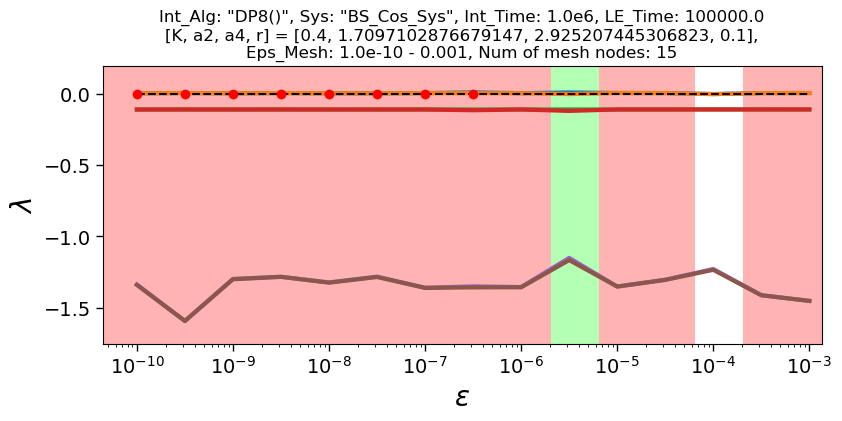

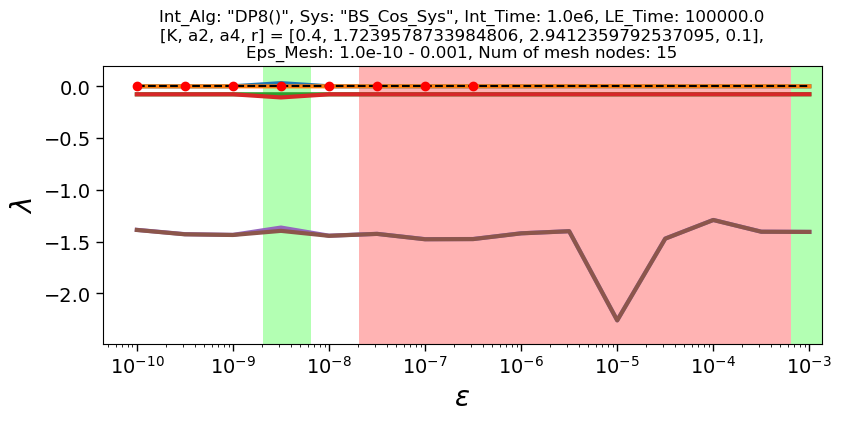

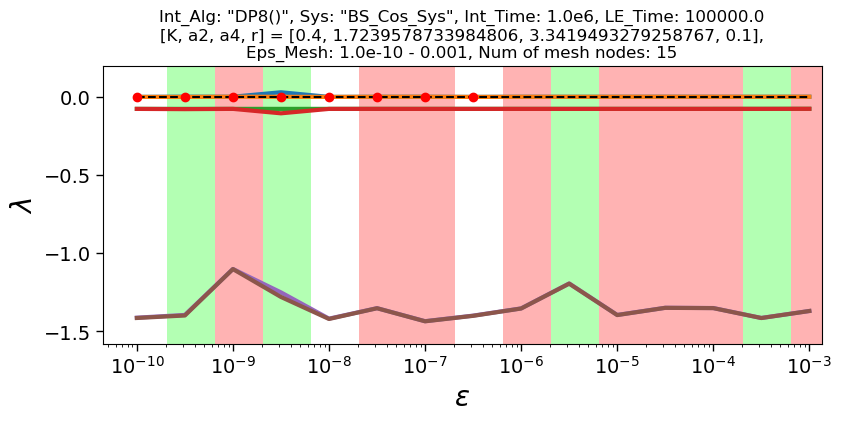

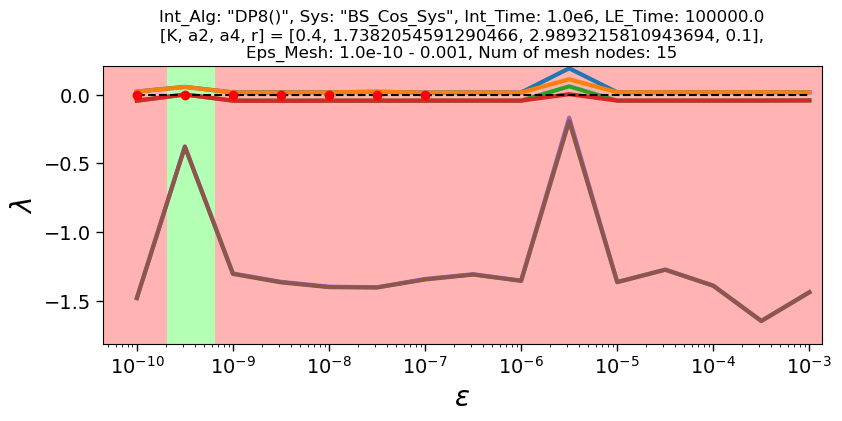

In [40]:
for (i, j) = MRA_POI[41 : 52]
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

---

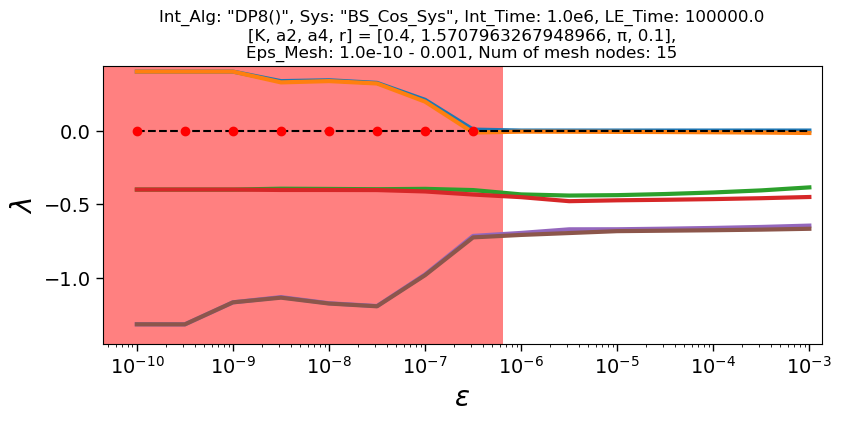

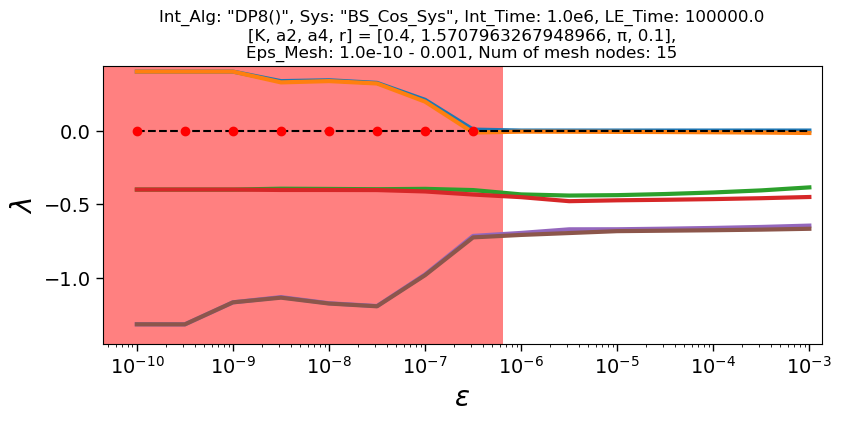

In [20]:
λs = zeros(length(Eps_mesh), 7)

a2_cur = pi/2
a4_cur = pi

SP = SystemParameters(K, a2_cur, a4_cur, r, Eps_mesh)
λs = LEs_execution(SP, NP)
fig = LLE_plot(λs, SP, NP)

---

In [31]:
Sdl = zeros(Resolution, Resolution)
Sdl_border = 1
Sdl_POI = []

for (i, j) = [[p, m] for p in 1:Resolution for m in 1:Resolution]
    λs = λs_s[i, j, :, :]
    if any(i -> i != 0, λs[:, 1:6])
        Sdls = length(Eps_mesh)
        for k = 1 : length(Eps_mesh)
            if λs[k, 7] == 1
                Sdls = Sdls - 1
            end
        end
        Sdl[i, j] = Sdls
        if Sdls <= Sdl_border
            push!(Sdl_POI, [i, j])
        end
    else
    Sdl[i, j] = NaN    
    end
end

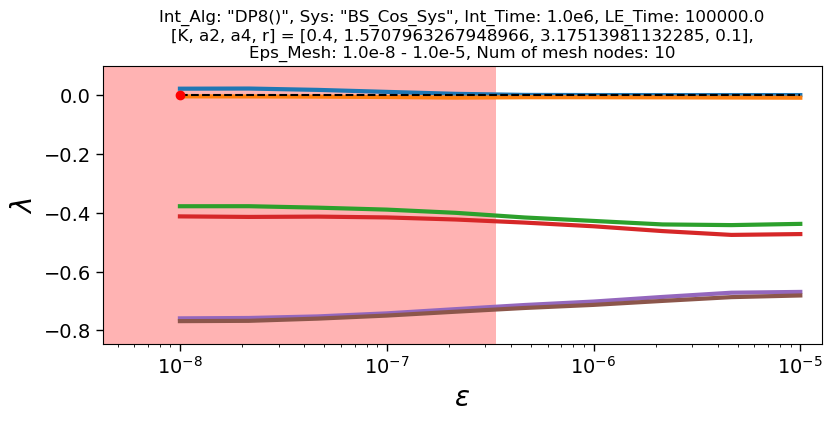

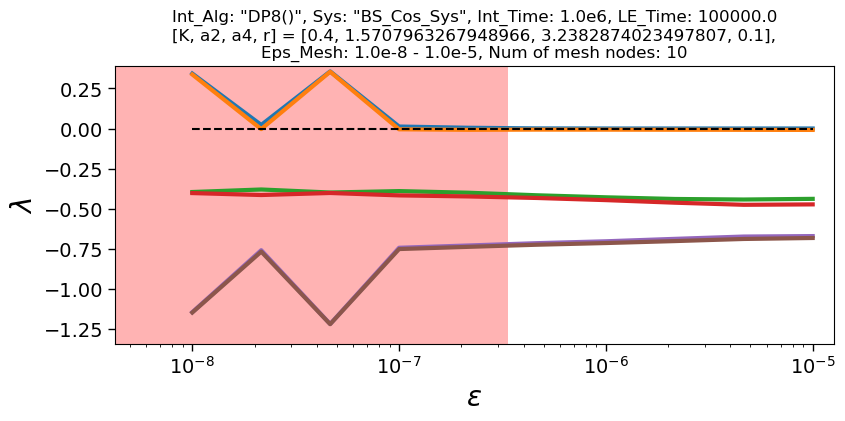

In [33]:
for (i, j) = Sdl_POI
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

In [42]:
λs_s[1, 99, :, :]

10×7 Matrix{Float64}:
 0.34212       0.33639     -0.395431  -0.402106  -1.14363   -1.14573   1.0
 0.0222241    -0.00367163  -0.379714  -0.414233  -0.757704  -0.766722  1.0
 0.355575      0.353454    -0.39857   -0.401547  -1.21731   -1.21835   1.0
 0.0123143    -0.00509569  -0.389703  -0.416574  -0.742513  -0.750642  1.0
 0.00468904   -0.00827377  -0.399784  -0.42299   -0.728353  -0.736954  1.0
 0.000648638  -0.00699982  -0.415726  -0.432667  -0.713931  -0.72373   1.0
 4.57747e-5   -0.00733137  -0.428384  -0.445975  -0.702196  -0.713218  1.0
 4.18266e-5   -0.00778465  -0.43874   -0.46201   -0.687107  -0.701087  1.0
 7.28313e-5   -0.00830885  -0.44221   -0.475089  -0.672679  -0.68784   1.0
 6.39199e-5   -0.00893296  -0.438017  -0.472521  -0.669786  -0.681768  1.0

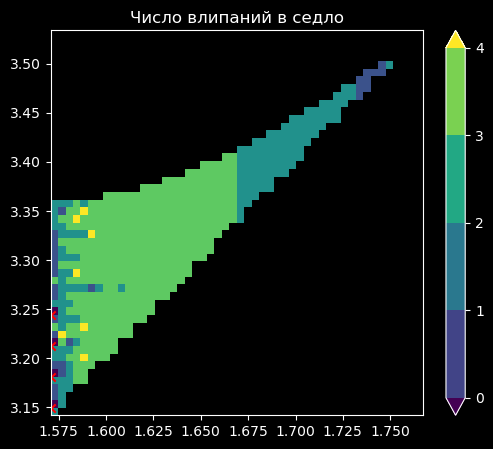

In [291]:
Plot_map(A2, A4, Sdl, "Число влипаний в седло", Sdl_POI)

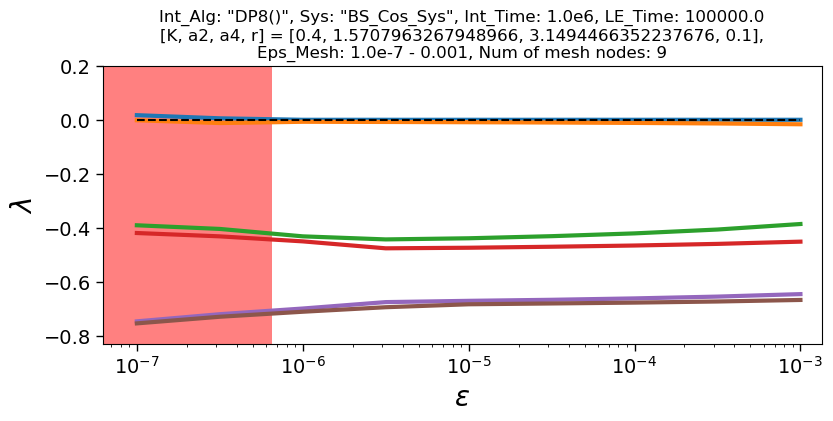

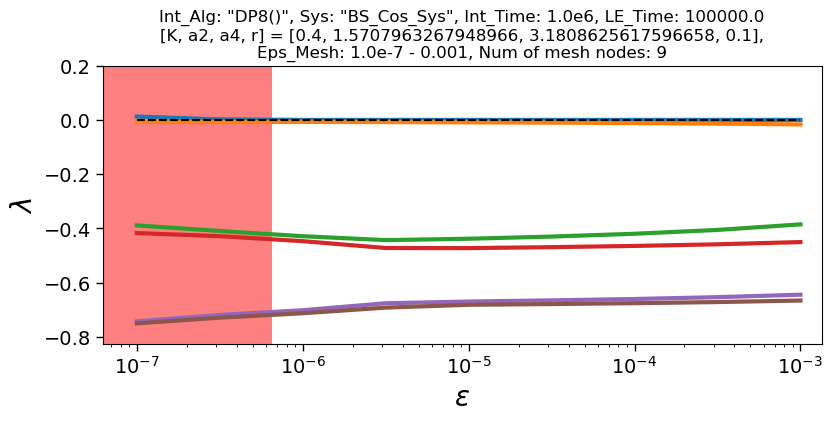

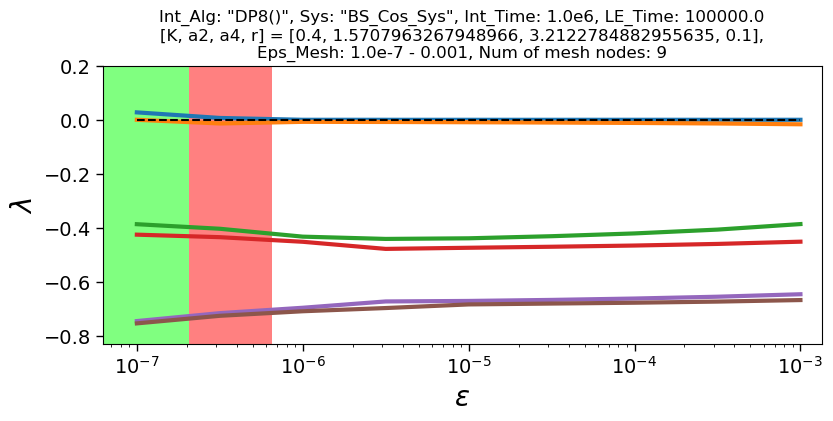

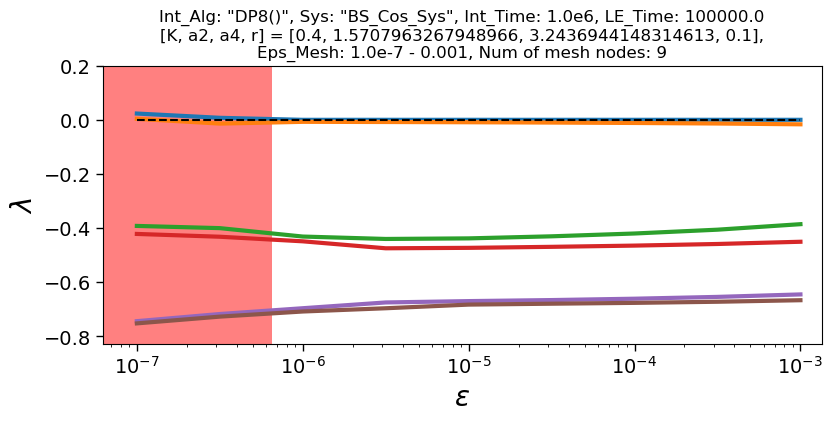

In [292]:
for (i, j) = Sdl_POI
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

---

In [293]:
Zeros = zeros(Resolution, Resolution)
Zeros_Border = 9
Zeros_POI = []

for (i, j) = [[p, m] for p in 1:Resolution for m in 1:Resolution]
    λs = λs_s[i, j, :, 1:6]
    if any(i -> i != 0, λs[:, 1:6])
        Zer = Eps_Length
        for k = 1 : length(Eps_mesh)
            if all(i -> abs(i) > 1e-3, λs[k])
                Zer = Zer - 1
            end
        end
        Zeros[i, j] = Zer
        if Zer >= Zeros_Border
            push!(Zeros_POI, [A2[i], A4[j]])
        end
    else
        Zeros[i, j] = NaN
    end
end

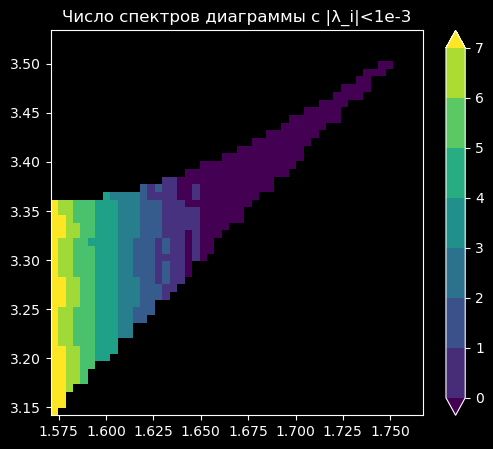

In [294]:
Plot_map(A2, A4, Zeros, "Число спектров диаграммы с |λ_i|<1e-3", [])

---

In [295]:
Maxus = zeros(Resolution, Resolution)
Maxus_border = 0.7
Maxus_POI = []

for (i, j) = [[p, m] for p in 1:Resolution for m in 1:Resolution]

    λs = λs_s[i, j, :, 1:6]
    if any(i -> i != 0, λs[:, 1:6])
        Maxus[i, j] = maximum(λs)
        if Maxus[i, j] >= Maxus_border
            push!(Maxus_POI, [i, j])
        end
    else
        Maxus[i, j] = NaN
    end

end

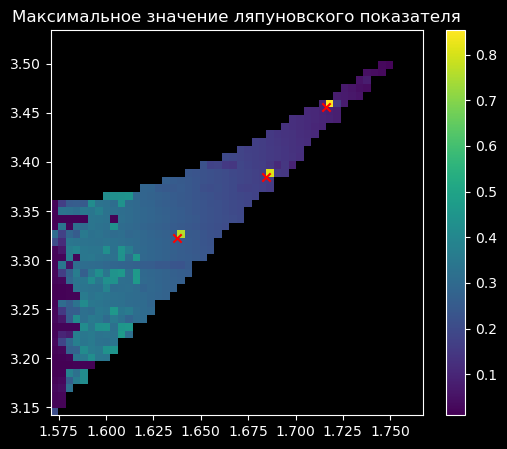

In [296]:
Plot_map(A2, A4, Maxus, "Максимальное значение ляпуновского показателя", Maxus_POI)

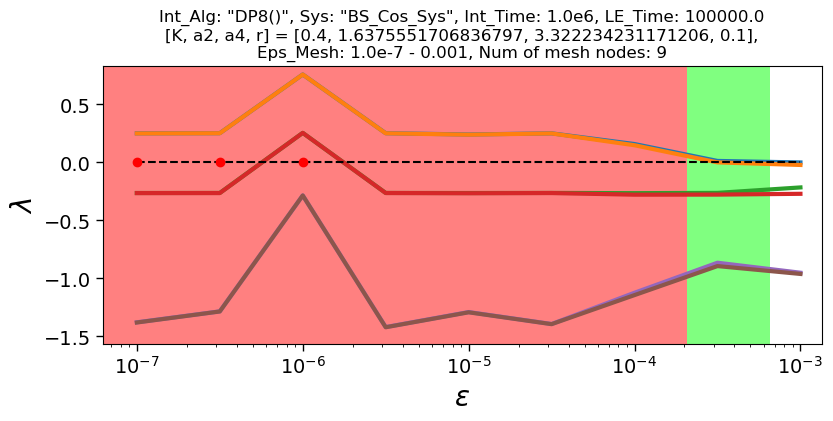

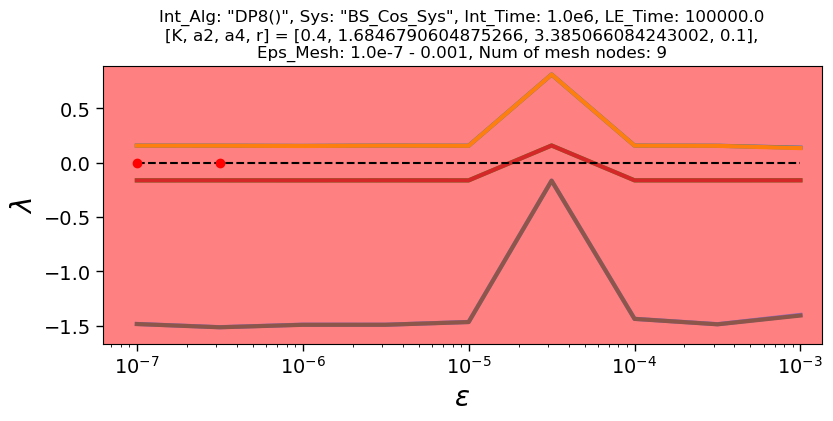

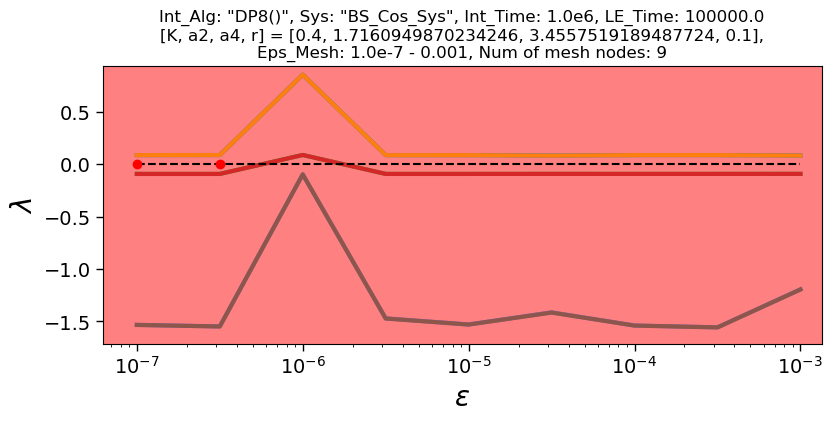

In [297]:
for (i, j) = Maxus_POI
    λs = λs_s[i, j, :, :]
    SP = SystemParameters(K, A2[i], A4[j], r, Eps_mesh)
    fig = LLE_plot(λs, SP, NP)
end 

In [37]:
LE_map = zeros(Resolution, Eps_Length)

for i = 1 : Resolution
    for k = 1 : Eps_Length
        
        λs = λs_s[1, i, k, 1:6]
        if any(i -> i != 0, λs[:, :])
            RateVal = 0

            if any(i -> abs(i) < 1e-3, λs)
                RateVal = RateVal + 1
                if any(i -> i > 1e-3, λs)
                    RateVal = RateVal + 1
                end
            end
            
            LE_map[i, k] = RateVal
        else
            LE_map[i, k] = NaN
        end
        
    end
end

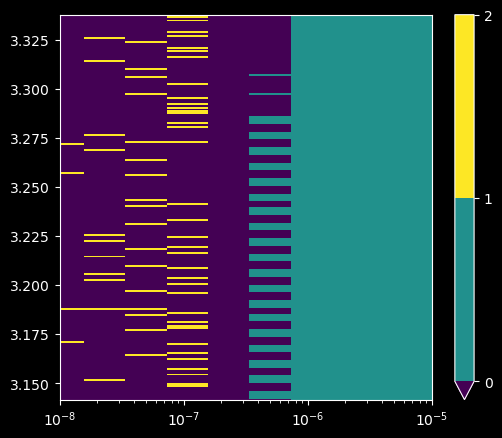

In [72]:
plt.style.use("dark_background")

fig = figure(figsize=(6, 5))

cmap = matplotlib.cm.viridis

bounds = sort(unique(LE_map))
if isnan(bounds[end])
    bounds = bounds[1 : end-1]
end

norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend="min")
pcm = plt.pcolormesh(Eps_mesh, A4, LE_map, vmin=minimum(bounds), vmax=maximum(bounds))
colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))



fig.gca().set_xscale("log")
fig.gca().set_xlim([Eps_mesh[1], Eps_mesh[end]])
fig.gca().set_ylim([A4[1], A4[end]])

plt.style.use("default")

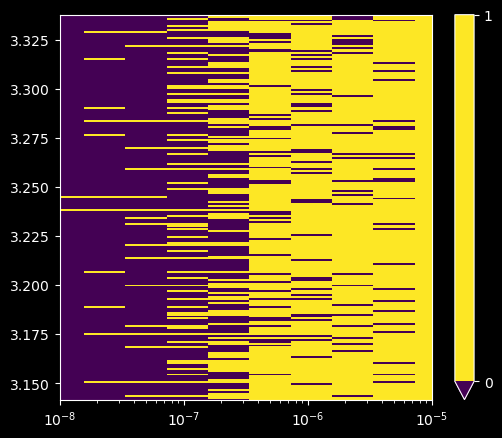

In [81]:
fig = figure(figsize=(6, 5))

cmap = matplotlib.cm.viridis

bounds = [0, 1]

norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend="min")
pcm = plt.pcolormesh(Eps_mesh, A4, λs_s[1, :, :, 7], vmin=minimum(bounds), vmax=maximum(bounds))
colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))



fig.gca().set_xscale("log")
fig.gca().set_xlim([Eps_mesh[1], Eps_mesh[end]])
fig.gca().set_ylim([A4[1], A4[end]])

plt.style.use("default")